# DeepLearning for TCGA Data

## Librerias

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import dask_ml.joblib
from matplotlib import pyplot

C:\Users\da.salazarb\AppData\Local\Continuum\anaconda3\envs\PythonR\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

Los datos provienen de __[FireHose Brad GDAC](https://gdac.broadinstitute.org/)__ y del paquete de R __[TCGA-Assembler](https://github.com/compgenome365/TCGA-Assembler-2)__. 

En el archivo de R *Depuracion_TCGA-Assembler_Integrator.R* se realizo la consolidacion de los archivos. Se trabajo **cnv**, **meth** y **mrna**. Por tal motivo los archivos quedaron listo para usar, sin embargo, se requiere de preprocesameinto para **mrna**. Los genes de este dataSet tienen una varianza diversa, es decir, varianzas cercanas a cero y otras que superan el millon.

El siguiente documento vendra organizado por: <br>
1. [Funciones](#Funciones)
2. [PreprossData](#PreprossData)
3. [ANN](#ANN)

In [3]:
## Cual es la ruta actual?
os.getcwd()

'C:\\Users\\da.salazarb\\Google Drive\\Tutorial_2018-10\\03_Resultados\\DataTCGA'

******************************************************************************************************************************************

### Para cargar nuevamente los archivos de forma rapida

In [3]:
#Para cargar nuevamente los archivos de forma rapida
def reRunFiles(varX=False, logSurv=False):
    mrna=pd.read_table("TCGA-Integrator/mrnaPrePros.txt")
    cnv=pd.read_table("TCGA-Integrator/cnvPrePros.txt")
    meth=pd.read_table("TCGA-Integrator/methPrePros.txt")
    dsurv=pd.read_table("TCGA-Integrator/dsurvPrePros.txt")
    protein=pd.read_table("TCGA-Integrator/new_gbm_Protein.txt", sep=",", index_col=0)
    # Los archivos vienen con una columna "X" que contiene los indices de los pacientes
    # si varX == True -> se elimina esa primera columna
    if varX == True:
        mrna=mrna.iloc[:,1:]
        cnv=cnv.iloc[:,1:]
        meth=meth.iloc[:,1:]
        dsurv=dsurv.iloc[:,1:]
    # Logaritmo a dsurv
    if logSurv == True:
        dsurv=np.log10(dsurv)
    # correccion de nombres para protein
    nombreProteinIndex=list(protein.index)
    nombreProteinIndex = [w.replace('-', '.') for w in nombreProteinIndex]
    protein.index=nombreProteinIndex
    protein=protein.loc[mrna.index,:]
    
    print("Dimensiones mrna: {0}".format(mrna.shape))
    print("Dimensiones cnv: {0}".format(cnv.shape))
    print("Dimensiones meth: {0}".format(meth.shape))
    print("Dimensiones dsurv: {0}".format(dsurv.shape))
    print("Dimensiones protein: {0}".format(protein.shape))
    return mrna, cnv, meth, dsurv, protein

In [4]:
# Antes correr la funcion reRunFiles()

mrna, cnv, meth, dsurv, protein = reRunFiles(varX=True, logSurv=True)

Dimensiones mrna: (160, 11695)
Dimensiones cnv: (160, 23608)
Dimensiones meth: (160, 13774)
Dimensiones dsurv: (160, 1)
Dimensiones protein: (160, 138)


Pasar a 
1. [Funciones](#Funciones)
2. [PreprossData](#PreprossData)
3. [ANN](#ANN)

### mrna

In [ ]:
mrna=pd.read_table("TCGA-Integrator/mrnaPrePros.txt")

In [5]:
mrna.head()

X      A1BG     A2ML1         A2M    A4GALT  \
TCGA.02.0047.01  TCGA.02.0047.01  125.0069   41.1814  34012.4220   36.2642   
TCGA.02.0055.01  TCGA.02.0055.01  391.8038    1.6819  42876.2607  487.7365   
TCGA.02.2483.01  TCGA.02.2483.01  271.8522    2.5330  21058.5203   86.9657   
TCGA.02.2485.01  TCGA.02.2485.01   83.9429  211.4286   7798.5333  155.2381   
TCGA.02.2486.01  TCGA.02.2486.01  108.2561  103.6585  40971.4268   43.9024   

                  A4GNT       AAAS      AACS   AADAC     AADAT    ...     \
TCGA.02.0047.01  1.2293   466.5171  481.8833  0.0000  233.5659    ...      
TCGA.02.0055.01  0.5606   594.8143  317.3090  0.5606   99.7898    ...      
TCGA.02.2483.01  0.0000  1100.5805  493.0871  0.0000  259.2084    ...      
TCGA.02.2485.01  0.4762  1013.8095  304.2857  0.4762  190.0000    ...      
TCGA.02.2486.01  0.0000   701.8293  392.0732  0.0000  217.0732    ...      

                  ZSCAN5A    ZSWIM1    ZSWIM3    ZSWIM7      ZW10    ZWILCH  \
TCGA.02.0047.01   92.8117  248.3174  107.5632  311.3618  288.2695  260.2108   
TCGA.02.0055.01   61.6678  266.8535   96.4261  313.5361  366.6433  467.5599   
TCGA.02.2483.01  115.2507  258.3641  154.9340  455.5061  551.3456  682.2417   
TCGA.02.2485.01  230.0000  267.1429  121.9048  330.5095  342.3810  440.3857   
TCGA.02.2486.01   87.8049  251.8293  119.5122  972.3659  420.7317  166.6890   

                    ZWINT         ZYX      ZZEF1      ZZZ3  
TCGA.02.0047.01  404.4378   3867.9738  1397.0927  603.5834  
TCGA.02.0055.01  245.5501  11481.4296   606.0266  718.1500  
TCGA.02.2483.01  669.1293   5066.8074   832.0844  705.4354  
TCGA.02.2485.01  441.9048   5090.9524  1139.5238  700.4762  
TCGA.02.2486.01   74.3902   7800.0000   627.4390  527.4390  

[5 rows x 11696 columns]

### cnv

In [6]:
cnv=pd.read_table("TCGA-Integrator/cnvPrePros.txt")

In [8]:
cnv.head()

X  OR4F5_CHR1_pos_cnv  LOC729737_CHR1_neg_cnv  \
TCGA.02.0047.01  TCGA.02.0047.01             -0.0191               -0.019100   
TCGA.02.0055.01  TCGA.02.0055.01              0.1288                0.128800   
TCGA.02.2483.01  TCGA.02.2483.01              1.0976                0.045073   
TCGA.02.2485.01  TCGA.02.2485.01              0.5424                1.298800   
TCGA.02.2486.01  TCGA.02.2486.01              0.1420                0.142000   

                 LOC100132287_CHR1_pos_cnv  OR4F29_CHR1_pos_cnv  \
TCGA.02.0047.01                    -0.0191              -0.0191   
TCGA.02.0055.01                     0.1288               0.1288   
TCGA.02.2483.01                    -0.1359              -0.1359   
TCGA.02.2485.01                     0.0092               0.0092   
TCGA.02.2486.01                     0.1420               0.1420   

                 OR4F16_CHR1_neg_cnv  LOC100133331_CHR1_neg_cnv  \
TCGA.02.0047.01              -0.0191                    -0.0191   
TCGA.02.0055.01               0.1288                     0.1288   
TCGA.02.2483.01              -0.1359                    -0.1359   
TCGA.02.2485.01               0.0092                     0.0092   
TCGA.02.2486.01               0.1420                     0.1420   

                 LOC100288069_CHR1_neg_cnv  LINC00115_CHR1_neg_cnv  \
TCGA.02.0047.01                    -0.0191                 -0.0191   
TCGA.02.0055.01                     0.1288                  0.1288   
TCGA.02.2483.01                    -0.1359                 -0.1359   
TCGA.02.2485.01                     0.0092                  0.0092   
TCGA.02.2486.01                     0.1420                 -1.3062   

                 LOC643837_CHR1_pos_cnv         ...          \
TCGA.02.0047.01               -0.019100         ...           
TCGA.02.0055.01                0.128800         ...           
TCGA.02.2483.01               -0.135900         ...           
TCGA.02.2485.01                0.009200         ...           
TCGA.02.2486.01               -0.237986         ...           

                 DAZ3_CHRY_neg_cnv  BPY2C_CHRY_neg_cnv  TTTY4_CHRY_neg_cnv  \
TCGA.02.0047.01            -0.9258             -0.9258             -0.9258   
TCGA.02.0055.01            -4.4689             -4.4689             -4.4689   
TCGA.02.2483.01            -0.9796             -0.9796             -0.9796   
TCGA.02.2485.01            -0.9720             -0.9707             -0.9707   
TCGA.02.2486.01            -0.9111             -0.9111             -0.9111   

                 TTTY4B_CHRY_neg_cnv  TTTY4C_CHRY_neg_cnv  \
TCGA.02.0047.01              -0.9258              -0.9258   
TCGA.02.0055.01              -4.4689              -4.4689   
TCGA.02.2483.01              -0.9796              -0.9796   
TCGA.02.2485.01              -0.9707              -0.9707   
TCGA.02.2486.01              -0.9111              -0.9111   

                 TTTY17C_CHRY_neg_cnv  GOLGA2P3Y_CHRY_pos_cnv  \
TCGA.02.0047.01             -0.925800                 -0.9258   
TCGA.02.0055.01             -3.171700                 -3.1717   
TCGA.02.2483.01             -1.597927                 -0.9831   
TCGA.02.2485.01             -1.597927                 -0.9445   
TCGA.02.2486.01             -0.911100                 -0.9111   

                 CSPG4P1Y_CHRY_pos_cnv  CDY1_CHRY_pos_cnv  TTTY3_CHRY_pos_cnv  
TCGA.02.0047.01                -0.9258            -0.9258             -0.9258  
TCGA.02.0055.01                -3.1717            -3.9009             -3.9009  
TCGA.02.2483.01                -0.9831            -0.9831             -0.9831  
TCGA.02.2485.01                -0.9445            -0.9445             -0.9445  
TCGA.02.2486.01                -0.9111            -0.9111             -0.9111  

[5 rows x 23609 columns]

### meth

In [9]:
meth=pd.read_table("TCGA-Integrator/methPrePros.txt")

In [11]:
meth.head()

X  A1BG_Met  A2BP1_Met   A2M_Met  A2ML1_Met  \
TCGA.02.0047.01  TCGA.02.0047.01  0.912566   0.034304  0.483260   0.828452   
TCGA.02.0055.01  TCGA.02.0055.01  0.971043   0.049076  0.434293   0.774517   
TCGA.02.2483.01  TCGA.02.2483.01  0.983366   0.017715  0.619654   0.753028   
TCGA.02.2485.01  TCGA.02.2485.01  0.986760   0.518796  0.882882   0.893858   
TCGA.02.2486.01  TCGA.02.2486.01  0.986283   0.094072  0.713892   0.870546   

                 A4GALT_Met  A4GNT_Met  AAAS_Met  AACS_Met  AADAC_Met  \
TCGA.02.0047.01    0.275331   0.880689  0.063332  0.019450   0.839998   
TCGA.02.0055.01    0.168746   0.836721  0.060909  0.019982   0.936717   
TCGA.02.2483.01    0.591275   0.800351  0.060531  0.117779   0.789232   
TCGA.02.2485.01    0.590924   0.754738  0.065106  0.093189   0.951085   
TCGA.02.2486.01    0.296626   0.910114  0.052955  0.018667   0.953567   

                   ...     ZSWIM1_Met  ZSWIM3_Met  ZSWIM7_Met  ZUFSP_Met  \
TCGA.02.0047.01    ...       0.120393    0.032276    0.041173   0.040014   
TCGA.02.0055.01    ...       0.067277    0.262254    0.042812   0.028531   
TCGA.02.2483.01    ...       0.031709    0.217831    0.017603   0.016413   
TCGA.02.2485.01    ...       0.032355    0.350205    0.017579   0.014839   
TCGA.02.2486.01    ...       0.027617    0.216898    0.017318   0.015095   

                 ZW10_Met  ZWILCH_Met  ZWINT_Met   ZYX_Met  ZZEF1_Met  \
TCGA.02.0047.01  0.030673    0.061051   0.017492  0.017421   0.018757   
TCGA.02.0055.01  0.030329    0.052327   0.021946  0.018055   0.024949   
TCGA.02.2483.01  0.017737    0.023825   0.016402  0.033462   0.017201   
TCGA.02.2485.01  0.014738    0.023565   0.018847  0.010565   0.016691   
TCGA.02.2486.01  0.015845    0.024834   0.018412  0.011906   0.017203   

                 ZZZ3_Met  
TCGA.02.0047.01  0.037643  
TCGA.02.0055.01  0.019041  
TCGA.02.2483.01  0.015024  
TCGA.02.2485.01  0.015303  
TCGA.02.2486.01  0.014688  

[5 rows x 13775 columns]

### Survival

In [12]:
dsurv=pd.read_table("TCGA-Integrator/dsurvPrePros.txt")

In [486]:
dsurv.head()

Survival
TCGA.02.0047.01  2.651278
TCGA.02.0055.01  1.880814
TCGA.02.2483.01  2.668386
TCGA.02.2485.01  2.672098
TCGA.02.2486.01  2.790988

### Protein

In [290]:
protein=pd.read_table("TCGA-Integrator/new_gbm_Protein.txt", sep=",", index_col=0)

In [292]:
# Arreglar los nombres de "-" a "."
nombreProteinIndex=list(protein.index)
nombreProteinIndex = [w.replace('-', '.') for w in nombreProteinIndex]
protein.index=nombreProteinIndex
#protein=protein.loc[mrna.index,:]

In [295]:
protein.head()

EIF4EBP1_Protein  EIF4EBP1_Protein.1  TP53BP1_Protein  \
TCGA.02.0047.01          0.010885            0.010885        -0.043513   
TCGA.02.0055.01          0.010885            0.010885        -0.043513   
TCGA.02.2483.01          0.010885            0.010885        -0.043513   
TCGA.02.2485.01          0.095068            0.095068        -0.286664   
TCGA.02.2486.01          0.010885            0.010885        -0.043513   

                 ARAF_Protein  ACACA_Protein  ACACA ACACB_Protein  \
TCGA.02.0047.01      0.051444      -0.113459            -0.107168   
TCGA.02.0055.01      0.051444      -0.113459            -0.107168   
TCGA.02.2483.01      0.051444      -0.113459            -0.107168   
TCGA.02.2485.01     -0.009376       0.018231             0.025766   
TCGA.02.2486.01      0.051444      -0.113459            -0.107168   

                 ADAR_Protein  PRKAA1_Protein  AR_Protein  ASNS_Protein  \
TCGA.02.0047.01     -0.001492       -0.186310    0.101801      0.056528   
TCGA.02.0055.01     -0.001492       -0.186310    0.101801      0.056528   
TCGA.02.2483.01     -0.001492       -0.186310    0.101801      0.056528   
TCGA.02.2485.01      0.395487       -0.191946    0.770233      0.666904   
TCGA.02.2486.01     -0.001492       -0.186310    0.101801      0.056528   

                       ...          MTOR_Protein  MTOR_Protein.1  \
TCGA.02.0047.01        ...             -0.088407       -0.088407   
TCGA.02.0055.01        ...             -0.088407       -0.088407   
TCGA.02.2483.01        ...             -0.088407       -0.088407   
TCGA.02.2485.01        ...             -0.204640       -0.204640   
TCGA.02.2486.01        ...             -0.088407       -0.088407   

                 CDKN2A_Protein  CDKN1A_Protein  CDKN1B_Protein  \
TCGA.02.0047.01        0.740885        0.062128        0.101323   
TCGA.02.0055.01        0.740885        0.062128        0.101323   
TCGA.02.2483.01        0.740885        0.062128        0.101323   
TCGA.02.2485.01        3.371783       -0.275471        0.178133   
TCGA.02.2486.01        0.740885        0.062128        0.101323   

                 MAPK14_Protein  MAPK14_Protein.1  SQSTM1_Protein  \
TCGA.02.0047.01       -0.020126         -0.020126        0.108921   
TCGA.02.0055.01       -0.020126         -0.020126        0.108921   
TCGA.02.2483.01       -0.020126         -0.020126        0.108921   
TCGA.02.2485.01       -0.072353         -0.072353       -0.377175   
TCGA.02.2486.01       -0.020126         -0.020126        0.108921   

                 RPS6KB1_Protein  RPS6KB1_Protein.1  
TCGA.02.0047.01        -0.053979          -0.053979  
TCGA.02.0055.01        -0.053979          -0.053979  
TCGA.02.2483.01        -0.053979          -0.053979  
TCGA.02.2485.01        -0.155672          -0.155672  
TCGA.02.2486.01        -0.053979          -0.053979  

[5 rows x 138 columns]

In [297]:
# Escoger los mismos pacientes que el peril de mrna
protein=protein.loc[mrna.index,:]

******************************************************************************************************************************************

## Funciones 
[Retornar al inicio](#Data)

In [5]:
#Multicolinealidad
def calculate_vif_(X, thresh=5.0):
    
    import time
    from statsmodels.stats.outliers_influence import variance_inflation_factor    
    from joblib import Parallel, delayed
    
    #variables = list(X.iloc[:,1:].columns)
    variables = list(X.columns)
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]

In [6]:
# Seleccion de variables para varianzas pequeñas
def varianceSelection(X, THRESHOLD = 10):
    from sklearn.feature_selection import VarianceThreshold
    sel = VarianceThreshold(threshold=THRESHOLD)
    sel.fit_transform(X)
    return X[[c for (s, c) in zip(sel.get_support(), X.columns.values) if s]]

In [7]:
# Normalizar los datos
def escalarData(tcga, x_train, x_test):
    '''
    tcga: el perfil por ejemplo, mrna.
    x_train y x_test: las particiones de ese perfil (e.g. mrna)
    
    '''
    from sklearn.preprocessing import StandardScaler
    
    sc_x = StandardScaler()
    sc_x.fit(tcga)
    x_train_s = sc_x.transform(x_train)
    x_test_s = sc_x.transform(x_test)
    x_train_s=pd.DataFrame(x_train_s, index=x_train.index, columns=x_train.columns)
    x_test_s=pd.DataFrame(x_test_s, index=x_test.index, columns=x_test.columns)
    return x_train, x_test

In [8]:
# Train y dev set para una muestra de variables para cada perfil
# correr despues de cargar los archivos
def demoTrainDevSet(mrna, cnv, meth, dsurv, protein):
    #Lista de 100 variables aleatoria
    mrnaLista=['JPH1', 'MT1X', 'NR2E3', 'PEX5L', 'CHST6', 'VEGFC', 'TPSD1', 'TMUB1', 'ACER1', 'OXER1', 'VAV3', 'HAND2', 'CYP11A1', 'HS3ST3B1', 'HIF3A', 'RPL21', 'LDLR', 'MUC15', 'PON2', 'WDR72', 'SH2D4B', 'SLC7A2', 'S100A3', 'RCVRN', 'USP29', 'AQP2', 'FAM83H', 'SPAG4', 'TP53I11', 'SORCS3', 'GLT1D1', 'CCIN', 'TFAP2B', 'GAD1', 'EPHX3', 'KRT17', 'GUCY2D', 'DIRAS2', 'HIST1H2AB']
    mrna=mrna[mrnaLista]
    
    #Lista de 100 variables aleatoria
    cnvLista=['FAM8A1_CHR6_pos_cnv', 'LSP1P3_CHR5_pos_cnv', 'CDCP1_CHR3_neg_cnv', 'RPS14_CHR5_neg_cnv', 'THOC2_CHRX_neg_cnv', 'GPR6_CHR6_pos_cnv', 'LRRC10B_CHR11_pos_cnv', 'TSSK3_CHR1_pos_cnv', 'ATP6V1A_CHR3_pos_cnv', 'PLGLB2_CHR2_pos_cnv', 'SNORD68_CHR16_pos_cnv', 'TRIM66_CHR11_neg_cnv', 'UBE2N_CHR12_neg_cnv', 'TAOK1_CHR17_pos_cnv', 'ARHGAP10_CHR4_pos_cnv', 'CCDC9_CHR19_pos_cnv', 'IFNA13_CHR9_neg_cnv', 'DOK7_CHR4_pos_cnv', 'RBM44_CHR2_pos_cnv', 'SNRNP48_CHR6_pos_cnv', 'B3GNT3_CHR19_pos_cnv', 'ALOX5AP_CHR13_pos_cnv', 'ATRX_CHRX_neg_cnv', 'LOC643650_CHR10_neg_cnv', 'SREBF2_CHR22_pos_cnv', 'SNAI1_CHR20_pos_cnv', 'SHC3_CHR9_neg_cnv', 'CBX3P2_CHR18_neg_cnv', 'GOLGA6C_CHR15_pos_cnv', 'MAGEB1_CHRX_pos_cnv', 'ARHGAP42_CHR11_pos_cnv', 'KCNK9_CHR8_neg_cnv', 'SOS1_CHR2_neg_cnv', 'SERPINA10_CHR14_neg_cnv', 'CLEC18A_CHR16_pos_cnv', 'PDCD1LG2_CHR9_pos_cnv', 'ROR1_CHR1_pos_cnv', 'APOBEC1_CHR12_neg_cnv', 'PRKD1_CHR14_neg_cnv', 'RNF41_CHR12_neg_cnv', 'COX6A2_CHR16_neg_cnv', 'RTL8B_CHRX_neg_cnv', 'MINDY1_CHR1_neg_cnv', 'F2RL2_CHR5_neg_cnv', 'LOXL2_CHR8_neg_cnv', 'LOC100498859_CHR3_pos_cnv', 'GK2_CHR4_neg_cnv', 'SNORD1A_CHR17_pos_cnv', 'LGSN_CHR6_neg_cnv', 'POLI_CHR18_pos_cnv', 'CD24_CHRY_neg_cnv', 'KLHL11_CHR17_neg_cnv']
    cnv=cnv[cnvLista]
    
    #Lista de 100 variables aleatoria
    methLista=['IL6_Met', 'KCNF1_Met', 'OSTBETA_Met', 'ITGA8_Met', 'ALOX15_Met', 'CCNL1_Met', 'CCM2_Met', 'CXCL1_Met', 'KCNH8_Met', 'RASD2_Met', 'TMEM49_Met', 'HLA.A_Met']
    meth=meth[methLista]
    
    #Lista de 100 variables aleatoria
    proteinLista=['XRCC5_Protein', 'FASN_Protein', 'CDKN1A_Protein', 'SMAD1_Protein', 'TFRC_Protein', 'BCL2_Protein', 'GAPDH_Protein', 'SYK_Protein', 'CDKN1B_Protein', 'NFKB1_Protein', 'PDCD4_Protein', 'RPS6_Protein.2', 'ERBB2_Protein', 'PCNA_Protein', 'MAPK14_Protein.1', 'CDK1_Protein', 'LCK_Protein', 'MYH11_Protein', 'G6PD_Protein', 'ASNS_Protein', 'AXL_Protein', 'AKT1 AKT2 AKT3_Protein.1', 'BECN1_Protein', 'ITGA2_Protein', 'PRKAA1_Protein', 'BRD4_Protein', 'CAV1_Protein', 'IRF1_Protein', 'SETD2_Protein', 'EGFR_Protein.1', 'CDH3_Protein', 'MAP2K1_Protein', 'SRC_Protein', 'MYH9_Protein']
    protein=protein[proteinLista]
    
    # Varianza
    mrna=varianceSelection(mrna, THRESHOLD=0.5)
    cnv=varianceSelection(cnv, THRESHOLD=0.01)
    meth=varianceSelection(meth, THRESHOLD=0.001)
    protein=varianceSelection(protein, THRESHOLD=0.1)
    
    # Obtener train y dev set de cada profile
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(mrna, dsurv.iloc[:,1:], test_size=.2)
    cnv_train=cnv.loc[x_train.index,]
    cnv_test=cnv.loc[x_test.index,]
    meth_train=meth.loc[x_train.index,]
    meth_test=meth.loc[x_test.index,]
    protein_train=protein.loc[x_train.index,]
    protein_test=protein.loc[x_test.index,]

    # Normalizar datos
    x_train, x_test = escalarData(mrna, x_train, x_test)
    cnv_train, cnv_test = escalarData(cnv, cnv_train, cnv_test)
    meth_train, meth_test = escalarData(meth, meth_train, meth_test)
    protein_train, protein_test = escalarData(protein, protein_train, protein_test)
    
    print("Nuevas dimensiones mrna: {0}".format(mrna.shape))
    print("Nuevas dimensiones cnv: {0}".format(cnv.shape))
    print("Nuevas dimensiones meth: {0}".format(meth.shape))
    print("Nuevas dimensiones dsurv: {0}".format(dsurv.shape))
    print("Nuevas dimensiones protein: {0}".format(protein.shape))
    
    return mrna, cnv, meth, dsurv, protein, x_train, x_test, y_train, y_test, cnv_train, cnv_test, meth_train, meth_test, protein_train, protein_test

In [9]:
#KFold para obtener los train y test de cada perfil
def kfoldProfiles(tcga, n_splits, seed): 
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    splits = kfold.split(tcga)
    return splits

## PreprossData
[Retornar al inicio](#Data)

## Seleccion de variables aleatorio

### mrna

In [491]:
variables=np.random.choice(len(mrna.columns), 100)
mrna=mrna.iloc[:,variables]
mrna.head()

ADRA1A     YBX2     MKNK1    TMEM50B     B3GAT3   KCNV2  \
TCGA.02.0047.01  63.3086   1.8439  592.1018  1241.5870  1078.7056  1.8439   
TCGA.02.0055.01  11.2123   1.6819  847.6524  2083.2516  1565.8024  1.6819   
TCGA.02.2483.01   4.2216  19.8417  407.3879  1083.7150  1000.1055  2.1108   
TCGA.02.2485.01  10.0000   4.7619  705.2810  1022.4238   829.5238  3.8095   
TCGA.02.2486.01   3.0488   0.0000  845.7805  2584.7561  1556.0976  0.6098   

                     RRAGA  STAMBPL1    CD1C    MRPL30    ...         MCM9  \
TCGA.02.0047.01  2577.2150  256.9225  1.8439  679.7197    ...      49.1718   
TCGA.02.0055.01  2763.2796  174.9124  0.0000  914.3658    ...      62.7891   
TCGA.02.2483.01  2056.7810  137.6253  2.1108  951.6116    ...      16.4644   
TCGA.02.2485.01  2577.1429   70.4762  2.3810  508.4333    ...      38.5714   
TCGA.02.2486.01  2081.7073  247.5610  0.6098  966.0305    ...      51.8293   

                      UBR3  HIST1H2BF       OASL       BRI3    FGFBP3  \
TCGA.02.0047.01  1135.2531     2.4586    46.7132   903.5311  400.7499   
TCGA.02.0055.01   774.2116     0.0000   186.6854  3081.7099   35.3189   
TCGA.02.2483.01   729.4987     0.8443    73.8786  1712.2955  398.9446   
TCGA.02.2485.01   616.6667     0.4762  1003.8095  1275.7143  328.0952   
TCGA.02.2486.01   473.1707     1.2195  2059.1463  4107.6646   51.8293   

                      SOX9        PGD    CCDC115      CDCA5  
TCGA.02.0047.01  4936.2304  2747.4723   685.9461   353.4220  
TCGA.02.0055.01   976.0336  3461.2474   593.6931   253.9594  
TCGA.02.2483.01  4436.9393  3879.2612   886.9657  1347.9683  
TCGA.02.2485.01  9390.0000  3495.7143   796.6667   588.5714  
TCGA.02.2486.01  1536.5854  3417.6829  1089.6341    79.2683  

[5 rows x 100 columns]

In [492]:
len(list(mrna.columns))

100

### cnv

In [493]:
variables=np.random.choice(len(cnv.columns), 100)
cnv=cnv.iloc[:,variables]
cnv.head()

IVNS1ABP_CHR1_neg_cnv  MIR5692C2_CHR10_pos_cnv  \
TCGA.02.0047.01                 0.0788                   0.0158   
TCGA.02.0055.01                 0.1212                  -0.2772   
TCGA.02.2483.01                 0.1753                  -0.6061   
TCGA.02.2485.01                 0.0529                  -0.9019   
TCGA.02.2486.01                 0.0733                  -0.5494   

                 CHPF_CHR2_neg_cnv  HLTF.AS1_CHR3_pos_cnv  \
TCGA.02.0047.01             0.0180                 0.1394   
TCGA.02.0055.01            -0.0232                -0.0432   
TCGA.02.2483.01            -0.0142                 0.0858   
TCGA.02.2485.01             0.0607                 0.0625   
TCGA.02.2486.01             0.0699                 0.0766   

                 MRPL32_CHR7_pos_cnv  BLVRB_CHR19_neg_cnv  \
TCGA.02.0047.01               0.0236              -0.0179   
TCGA.02.0055.01               0.2620              -0.0749   
TCGA.02.2483.01               0.0888               0.1039   
TCGA.02.2485.01               0.3492               0.4807   
TCGA.02.2486.01               0.5063               0.0833   

                 ZNF446_CHR19_pos_cnv  MRPL23.AS1_CHR11_neg_cnv  \
TCGA.02.0047.01               -0.0377                   -0.6072   
TCGA.02.0055.01               -0.0975                   -0.1184   
TCGA.02.2483.01                0.1495                   -0.7958   
TCGA.02.2485.01                0.5708                    0.0167   
TCGA.02.2486.01                0.1104                    0.0795   

                 GJB2_CHR13_neg_cnv  OR13J1_CHR9_neg_cnv  \
TCGA.02.0047.01              0.0137               0.0220   
TCGA.02.0055.01             -0.2362               0.0851   
TCGA.02.2483.01             -0.3102               0.0898   
TCGA.02.2485.01              0.0412               0.0399   
TCGA.02.2486.01              0.0843               0.1038   

                         ...           ESYT3_CHR3_pos_cnv  \
TCGA.02.0047.01          ...                       0.1394   
TCGA.02.0055.01          ...                      -0.0432   
TCGA.02.2483.01          ...                       0.0858   
TCGA.02.2485.01          ...                       0.0625   
TCGA.02.2486.01          ...                       0.0766   

                 GDF15_CHR19_pos_cnv  ELP3_CHR8_pos_cnv  PFDN4_CHR20_pos_cnv  \
TCGA.02.0047.01              -0.0010             0.0073               0.0203   
TCGA.02.0055.01              -0.0431             0.2955               0.2495   
TCGA.02.2483.01               0.1243             0.0987               0.0623   
TCGA.02.2485.01               0.4511             0.0336               0.0086   
TCGA.02.2486.01               0.0898            -0.4721               0.1096   

                 HIST1H1A_CHR6_neg_cnv  POLR3GL_CHR1_neg_cnv  \
TCGA.02.0047.01                 0.0227                0.0370   
TCGA.02.0055.01                 0.1210                0.1609   
TCGA.02.2483.01                 0.0957                0.0983   
TCGA.02.2485.01                 0.0354                0.0768   
TCGA.02.2486.01                 0.0715                0.0982   

                 DCXR_CHR17_neg_cnv  CPLX3_CHR15_pos_cnv  \
TCGA.02.0047.01              0.4344              -0.1614   
TCGA.02.0055.01             -0.2254               0.1458   
TCGA.02.2483.01             -0.0571              -0.0012   
TCGA.02.2485.01             -0.0138               0.0184   
TCGA.02.2486.01              0.0962               0.1004   

                 DEFB123_CHR20_pos_cnv  ABHD17B_CHR9_neg_cnv  
TCGA.02.0047.01                 0.0203                0.0244  
TCGA.02.0055.01                 0.2684                0.0341  
TCGA.02.2483.01                 0.1040                0.0567  
TCGA.02.2485.01                 0.0086                0.0465  
TCGA.02.2486.01                 0.1063                0.0907  

[5 rows x 100 columns]

In [494]:
len(list(cnv.columns))

100

### meth

In [495]:
variables=np.random.choice(len(meth.columns), 100)
meth=meth.iloc[:,variables]
meth.head()

ABHD1_Met  UBE2G1_Met  LOC220930_Met  DYNLL1_Met  NAGS_Met  \
TCGA.02.0047.01   0.033393    0.031587       0.170132    0.083595  0.151418   
TCGA.02.0055.01   0.037106    0.040729       0.199320    0.090089  0.209605   
TCGA.02.2483.01   0.018519    0.027024       0.419972    0.067191  0.680789   
TCGA.02.2485.01   0.019041    0.357032       0.361626    0.067761  0.231037   
TCGA.02.2486.01   0.014394    0.033789       0.316841    0.063870  0.161142   

                 STAM2_Met  FLYWCH2_Met  LYSMD4_Met  AZU1_Met  RPL4_Met  \
TCGA.02.0047.01   0.075490     0.013893    0.459247  0.572241  0.061051   
TCGA.02.0055.01   0.075758     0.017703    0.446411  0.886606  0.052327   
TCGA.02.2483.01   0.017379     0.023989    0.705461  0.813010  0.023825   
TCGA.02.2485.01   0.017180     0.021244    0.476258  0.665510  0.023565   
TCGA.02.2486.01   0.022815     0.018656    0.479291  0.616383  0.024834   

                     ...       PANK4_Met  FAM55C_Met  PLA2G3_Met  BIRC5_Met  \
TCGA.02.0047.01      ...        0.057230    0.096786    0.392943   0.011714   
TCGA.02.0055.01      ...        0.043925    0.061963    0.334450   0.014825   
TCGA.02.2483.01      ...        0.040837    0.023683    0.664727   0.010795   
TCGA.02.2485.01      ...        0.053324    0.024301    0.105098   0.012155   
TCGA.02.2486.01      ...        0.024709    0.019303    0.449662   0.014020   

                 CERCAM_Met  HIST1H2AM_Met  SLC39A9_Met  NUCB2_Met  NGRN_Met  \
TCGA.02.0047.01    0.019921       0.086862     0.050123   0.019260  0.025845   
TCGA.02.0055.01    0.024518       0.035479     0.034813   0.024946  0.016234   
TCGA.02.2483.01    0.010944       0.020672     0.017129   0.014478  0.013266   
TCGA.02.2485.01    0.011995       0.020720     0.014413   0.011949  0.012249   
TCGA.02.2486.01    0.015763       0.018903     0.017244   0.011486  0.012131   

                 C11orf65_Met  
TCGA.02.0047.01      0.649703  
TCGA.02.0055.01      0.028449  
TCGA.02.2483.01      0.098481  
TCGA.02.2485.01      0.015859  
TCGA.02.2486.01      0.014222  

[5 rows x 100 columns]

In [496]:
len(list(meth.columns))

100

### protein

In [497]:
variables=np.random.choice(len(protein.columns), 100)
protein=protein.iloc[:,variables]
protein.head()

SRC_Protein.1  AR_Protein  RPTOR_Protein  ERBB2_Protein.1  \
TCGA.02.0047.01       0.067899    0.101801      -0.046188        -0.057082   
TCGA.02.0055.01       0.067899    0.101801      -0.046188        -0.057082   
TCGA.02.2483.01       0.067899    0.101801      -0.046188        -0.057082   
TCGA.02.2485.01      -0.082088    0.770233      -0.126806        -0.757360   
TCGA.02.2486.01       0.067899    0.101801      -0.046188        -0.057082   

                 CDKN1B_Protein  CDH1_Protein  RAB11A RAB11B_Protein  \
TCGA.02.0047.01        0.101323      0.179834               0.015881   
TCGA.02.0055.01        0.101323      0.179834               0.015881   
TCGA.02.2483.01        0.101323      0.179834               0.015881   
TCGA.02.2485.01        0.178133     -0.150066               0.029899   
TCGA.02.2486.01        0.101323      0.179834               0.015881   

                 YBX1_Protein  CDH3_Protein  CLDN7_Protein      ...        \
TCGA.02.0047.01      0.007188      0.079147       0.054312      ...         
TCGA.02.0055.01      0.007188      0.079147       0.054312      ...         
TCGA.02.2483.01      0.007188      0.079147       0.054312      ...         
TCGA.02.2485.01     -0.519333     -0.191976      -0.031037      ...         
TCGA.02.2486.01      0.007188      0.079147       0.054312      ...         

                 SYK_Protein  NRG1_Protein  MYH9_Protein.1  KDR_Protein  \
TCGA.02.0047.01    -0.055340      0.036190       -0.136347     0.080083   
TCGA.02.0055.01    -0.055340      0.036190       -0.136347     0.080083   
TCGA.02.2483.01    -0.055340      0.036190       -0.136347     0.080083   
TCGA.02.2485.01    -0.407043      0.244137        0.047368    -0.432020   
TCGA.02.2486.01    -0.055340      0.036190       -0.136347     0.080083   

                 XRCC5_Protein  GAB2_Protein  RPS6KB1_Protein  \
TCGA.02.0047.01      -0.030525      0.057011        -0.053979   
TCGA.02.0055.01      -0.030525      0.057011        -0.053979   
TCGA.02.2483.01      -0.030525      0.057011        -0.053979   
TCGA.02.2485.01       0.375937     -0.671011        -0.155672   
TCGA.02.2486.01      -0.030525      0.057011        -0.053979   

                 RAB11A RAB11B_Protein  RB1_Protein  NFKB1_Protein  
TCGA.02.0047.01               0.015881     0.132179      -0.007908  
TCGA.02.0055.01               0.015881     0.132179      -0.007908  
TCGA.02.2483.01               0.015881     0.132179      -0.007908  
TCGA.02.2485.01               0.029899     0.761455      -0.912778  
TCGA.02.2486.01               0.015881     0.132179      -0.007908  

[5 rows x 100 columns]

In [498]:
len(list(protein.columns))

100

## Multicolinealidad

### mrna

In [14]:
#mrna=calculate_vif_(mrna.iloc[:,1:100],5)
mrna=calculate_vif_(mrna,5)

100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.9s finished


Sat Jun 30 14:34:49 2018 dropping 'LRRC59' at index: 34
99


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  84 out of  99 | elapsed:   17.3s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   17.6s finished


Sat Jun 30 14:35:07 2018 dropping 'VPS4A' at index: 56
98


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   17.1s finished


Sat Jun 30 14:35:25 2018 dropping 'WDR75' at index: 1
97


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  82 out of  97 | elapsed:   17.6s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   18.1s finished


Sat Jun 30 14:35:44 2018 dropping 'EIF2B1' at index: 38
96


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   30.1s finished


Sat Jun 30 14:36:14 2018 dropping 'CNOT8' at index: 4
95


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  80 out of  95 | elapsed:   16.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   18.5s finished


Sat Jun 30 14:36:33 2018 dropping 'SPAG9' at index: 14
94


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  79 out of  94 | elapsed:   18.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   19.1s finished


Sat Jun 30 14:36:53 2018 dropping 'AKAP8' at index: 69
93


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  59 out of  93 | elapsed:   15.9s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   16.1s finished


Sat Jun 30 14:37:09 2018 dropping 'PSMC2' at index: 66
92


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   17.7s finished


Sat Jun 30 14:37:28 2018 dropping 'CNBP' at index: 78
91


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   17.5s finished


Sat Jun 30 14:37:46 2018 dropping 'FIBP' at index: 67
90


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:   16.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.5s finished


Sat Jun 30 14:38:05 2018 dropping 'GMPR2' at index: 68
89


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   17.9s finished


Sat Jun 30 14:38:23 2018 dropping 'EPB41L5' at index: 12
88


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  55 out of  88 | elapsed:   16.4s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   16.7s finished


Sat Jun 30 14:38:40 2018 dropping 'CNPY2' at index: 27
87


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  72 out of  87 | elapsed:   16.4s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   16.8s finished


Sat Jun 30 14:38:57 2018 dropping 'KIAA0100' at index: 47
86


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   18.5s finished


Sat Jun 30 14:39:16 2018 dropping 'WDR47' at index: 30
85


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   32.7s finished


Sat Jun 30 14:39:49 2018 dropping 'NAA20' at index: 58
84


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   25.4s finished


Sat Jun 30 14:40:15 2018 dropping 'PEMT' at index: 55
83


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   17.0s finished


Sat Jun 30 14:40:33 2018 dropping 'NUP43' at index: 45
82


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  67 out of  82 | elapsed:   22.9s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   23.3s finished


Sat Jun 30 14:40:57 2018 dropping 'MSH2' at index: 4
81


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   19.9s finished


Sat Jun 30 14:41:17 2018 dropping 'HSPA13' at index: 42
80


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   18.4s finished


Sat Jun 30 14:41:36 2018 dropping 'TADA2A' at index: 19
79


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   19.4s finished


Sat Jun 30 14:41:56 2018 dropping 'EXOC2' at index: 64
78


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   18.1s finished


Sat Jun 30 14:42:14 2018 dropping 'PRMT7' at index: 26
77


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   17.8s finished


Sat Jun 30 14:42:33 2018 dropping 'DCAF13' at index: 61
76


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   21.3s finished


Sat Jun 30 14:42:54 2018 dropping 'THOC1' at index: 28
75


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   16.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   17.8s finished


Sat Jun 30 14:43:13 2018 dropping 'DMXL2' at index: 68
74


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   40.6s finished


Sat Jun 30 14:43:54 2018 dropping 'KLHL22' at index: 1
73


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   17.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   17.5s finished


Sat Jun 30 14:44:12 2018 dropping 'ZNF223' at index: 14
72


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   21.2s finished


Sat Jun 30 14:44:33 2018 dropping 'RNASET2' at index: 60
71


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   19.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   19.3s finished


Sat Jun 30 14:44:53 2018 dropping 'LCLAT1' at index: 68
70


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   17.4s finished


Sat Jun 30 14:45:11 2018 dropping 'SYPL1' at index: 29
69


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  54 out of  69 | elapsed:   16.5s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:   16.6s finished


Sat Jun 30 14:45:28 2018 dropping 'PNMA2' at index: 28
68


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  53 out of  68 | elapsed:   16.6s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   17.1s finished


Sat Jun 30 14:45:46 2018 dropping 'RAB8B' at index: 24
67


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   17.4s finished


Sat Jun 30 14:46:04 2018 dropping 'INVS' at index: 3
66


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  51 out of  66 | elapsed:   16.5s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   16.7s finished


Sat Jun 30 14:46:21 2018 dropping 'KIAA0556' at index: 65
65


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   25.0s finished


Sat Jun 30 14:46:46 2018 dropping 'SH3BP2' at index: 7
64


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  49 out of  64 | elapsed:   16.5s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   16.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   17.1s finished


Sat Jun 30 14:47:04 2018 dropping 'DIS3L' at index: 49
63


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  61 out of  63 | elapsed:   17.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   17.2s finished


Sat Jun 30 14:47:22 2018 dropping 'SLC25A37' at index: 61
62


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  60 out of  62 | elapsed:   16.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   16.7s finished


Sat Jun 30 14:47:39 2018 dropping 'DZIP1' at index: 55
61


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  59 out of  61 | elapsed:   17.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   17.3s finished


Sat Jun 30 14:47:57 2018 dropping 'FUZ' at index: 0
60


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   16.1s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   17.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.6s finished


Sat Jun 30 14:48:15 2018 dropping 'STYXL1' at index: 10
59


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:   16.5s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  56 out of  59 | elapsed:   17.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   17.4s finished


Sat Jun 30 14:48:33 2018 dropping 'AGAP1' at index: 1
58


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  55 out of  58 | elapsed:   20.2s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   20.2s finished


Sat Jun 30 14:48:53 2018 dropping 'ALDH3B1' at index: 16
57


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  54 out of  57 | elapsed:   21.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   21.2s finished


Sat Jun 30 14:49:15 2018 dropping 'MDN1' at index: 41
56


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  53 out of  56 | elapsed:   19.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   19.9s finished


Sat Jun 30 14:49:35 2018 dropping 'MAPK8IP2' at index: 9
55


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:   19.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   19.6s finished


Sat Jun 30 14:49:55 2018 dropping 'DUSP15' at index: 44
54


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  39 out of  54 | elapsed:   16.1s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  50 out of  54 | elapsed:   16.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   16.8s finished


Sat Jun 30 14:50:13 2018 dropping 'ETS2' at index: 6
53


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  49 out of  53 | elapsed:   16.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   17.1s finished


Sat Jun 30 14:50:30 2018 dropping 'KDM4C' at index: 29
52


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  48 out of  52 | elapsed:   16.6s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:   16.6s finished


Sat Jun 30 14:50:47 2018 dropping 'CCDC126' at index: 20
51


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  47 out of  51 | elapsed:   16.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   16.7s finished


Sat Jun 30 14:51:05 2018 dropping 'PSME2' at index: 8
50


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   16.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.3s finished


Sat Jun 30 14:51:21 2018 dropping 'PARD6G' at index: 14
49


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:   16.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:   16.7s finished


Sat Jun 30 14:51:39 2018 dropping 'BASP1' at index: 38
48


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:   16.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   16.2s finished


Sat Jun 30 14:51:55 2018 dropping 'LMNB1' at index: 8
47


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  42 out of  47 | elapsed:   16.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:   16.8s finished


Sat Jun 30 14:52:13 2018 dropping 'UACA' at index: 40
46


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  41 out of  46 | elapsed:   16.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   16.4s finished


Sat Jun 30 14:52:30 2018 dropping 'GEM' at index: 44
45


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   16.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   16.0s finished


Sat Jun 30 14:52:46 2018 dropping 'APBB3' at index: 4
44


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  38 out of  44 | elapsed:   16.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   16.8s finished


Sat Jun 30 14:53:03 2018 dropping 'POLR1C' at index: 36
43


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  37 out of  43 | elapsed:   16.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   16.4s finished


Sat Jun 30 14:53:20 2018 dropping 'STMN4' at index: 32
42


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  36 out of  42 | elapsed:   15.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   16.4s finished


Sat Jun 30 14:53:37 2018 dropping 'SEC11C' at index: 11
41


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  35 out of  41 | elapsed:   15.4s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   16.0s finished


Sat Jun 30 14:53:53 2018 dropping 'TRPM2' at index: 37
40


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   16.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.7s finished


Sat Jun 30 14:54:11 2018 dropping 'HUNK' at index: 12
39


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:   15.6s remaining:    3.3s


Remaining variables:
[['JPH1', 'MT1X', 'NR2E3', 'PEX5L', 'CHST6', 'VEGFC', 'TPSD1', 'TMUB1', 'ACER1', 'OXER1', 'VAV3', 'HAND2', 'CYP11A1', 'HS3ST3B1', 'HIF3A', 'RPL21', 'LDLR', 'MUC15', 'PON2', 'WDR72', 'SH2D4B', 'SLC7A2', 'S100A3', 'RCVRN', 'USP29', 'AQP2', 'FAM83H', 'SPAG4', 'TP53I11', 'SORCS3', 'GLT1D1', 'CCIN', 'TFAP2B', 'GAD1', 'EPHX3', 'KRT17', 'GUCY2D', 'DIRAS2', 'HIST1H2AB']]


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   16.1s finished


In [500]:
#Lista de 100 variables aleatoria
mrnaLista=['JPH1', 'MT1X', 'NR2E3', 'PEX5L', 'CHST6', 'VEGFC', 'TPSD1', 'TMUB1', 'ACER1', 'OXER1', 'VAV3', 'HAND2', 'CYP11A1', 'HS3ST3B1', 'HIF3A', 'RPL21', 'LDLR', 'MUC15', 'PON2', 'WDR72', 'SH2D4B', 'SLC7A2', 'S100A3', 'RCVRN', 'USP29', 'AQP2', 'FAM83H', 'SPAG4', 'TP53I11', 'SORCS3', 'GLT1D1', 'CCIN', 'TFAP2B', 'GAD1', 'EPHX3', 'KRT17', 'GUCY2D', 'DIRAS2', 'HIST1H2AB']

In [501]:
mrna=mrna[mrnaLista]

In [502]:
mrna.head()

JPH1       MT1X   NR2E3    PEX5L      CHST6     VEGFC  \
TCGA.02.0047.01  133.3784  1594.3944  1.2293  73.1430  3282.2152   12.2929   
TCGA.02.0055.01  220.8830  7969.1661  0.0000  15.1367   616.6783  321.7940   
TCGA.02.2483.01    8.4433  1361.4776  4.6438   5.0660    41.7942   40.5277   
TCGA.02.2485.01    7.6190  5455.2381  5.2381  27.6190   885.7143   21.9048   
TCGA.02.2486.01   83.5366  2228.6585  1.8293  46.3415   847.5610   24.3902   

                  TPSD1     TMUB1  ACER1    OXER1    ...        SORCS3  \
TCGA.02.0047.01  0.0000  435.1701    0.0  17.2101    ...      599.8955   
TCGA.02.0055.01  1.1212  913.8052    0.0  22.4247    ...       32.5158   
TCGA.02.2483.01  0.0000  741.3193    0.0   8.0211    ...      285.8047   
TCGA.02.2485.01  0.0000  858.5714    0.0   7.1429    ...       33.3333   
TCGA.02.2486.01  0.0000  831.0976    0.0  10.3659    ...       76.8293   

                  GLT1D1     CCIN    TFAP2B      GAD1    EPHX3     KRT17  \
TCGA.02.0047.01  71.2991  11.0636   12.9076  591.9051   6.7611   22.1273   
TCGA.02.0055.01  82.4107  37.5613    0.5606  187.8066  14.5760  760.1962   
TCGA.02.2483.01  68.8127   4.2216   19.4195  586.8074  12.2427    2.9551   
TCGA.02.2485.01  23.3333  10.4762  137.1429  771.9048   2.3810    9.0476   
TCGA.02.2486.01  25.6098  28.6585    0.0000   33.5366  38.4146   37.8049   

                 GUCY2D     DIRAS2  HIST1H2AB  
TCGA.02.0047.01  0.6146   479.4247     1.2293  
TCGA.02.0055.01  3.9243   108.1990     0.0000  
TCGA.02.2483.01  0.8443   441.1609     2.9551  
TCGA.02.2485.01  0.4762  1667.1429     0.4762  
TCGA.02.2486.01  1.8293    99.3902     0.0000  

[5 rows x 39 columns]

In [185]:
mrna.shape

(160, 39)

### cnv

In [177]:
#mrna=calculate_vif_(mrna.iloc[:,1:100],5)
cnv=calculate_vif_(cnv,5)

100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.0s finished


Tue Jul  3 08:23:24 2018 dropping 'NKAP_CHRX_neg_cnv' at index: 18
99


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  84 out of  99 | elapsed:   15.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   15.9s finished


Tue Jul  3 08:23:40 2018 dropping 'ELAVL1_CHR19_neg_cnv' at index: 72
98


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   16.1s finished


Tue Jul  3 08:23:57 2018 dropping 'GPC3_CHRX_neg_cnv' at index: 30
97


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  82 out of  97 | elapsed:   15.5s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   15.7s finished


Tue Jul  3 08:24:13 2018 dropping 'PGM3_CHR6_neg_cnv' at index: 47
96


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  81 out of  96 | elapsed:   15.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   16.0s finished


Tue Jul  3 08:24:30 2018 dropping 'LYRM7_CHR5_pos_cnv' at index: 51
95


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  60 out of  95 | elapsed:   15.6s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   15.9s finished


Tue Jul  3 08:24:46 2018 dropping 'ANG_CHR14_pos_cnv' at index: 46
94


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  79 out of  94 | elapsed:   16.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   16.0s finished


Tue Jul  3 08:25:03 2018 dropping 'UBE3D_CHR6_neg_cnv' at index: 26
93


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  78 out of  93 | elapsed:   15.6s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   15.7s finished


Tue Jul  3 08:25:19 2018 dropping 'FAM24B.CUZD1_CHR10_neg_cnv' at index: 82
92


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:   16.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   16.9s finished


Tue Jul  3 08:25:37 2018 dropping 'BLCAP_CHR20_neg_cnv' at index: 23
91


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  76 out of  91 | elapsed:   16.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   16.1s finished


Tue Jul  3 08:25:54 2018 dropping 'AKAP14_CHRX_pos_cnv' at index: 83
90


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  75 out of  90 | elapsed:   14.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.0s finished


Tue Jul  3 08:26:09 2018 dropping 'EBF4_CHR20_pos_cnv' at index: 37
89


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   15.1s finished


Tue Jul  3 08:26:25 2018 dropping 'DPY19L2P4_CHR7_pos_cnv' at index: 24
88


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  73 out of  88 | elapsed:   15.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   15.2s finished


Tue Jul  3 08:26:41 2018 dropping 'RNASE8_CHR14_pos_cnv' at index: 13
87


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   15.2s finished


Tue Jul  3 08:26:57 2018 dropping 'CLCN1_CHR7_pos_cnv' at index: 31
86


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  71 out of  86 | elapsed:   15.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   15.1s finished


Tue Jul  3 08:27:12 2018 dropping 'HHEX_CHR10_pos_cnv' at index: 82
85


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   15.2s finished


Tue Jul  3 08:27:28 2018 dropping 'NAPB_CHR20_neg_cnv' at index: 51
84


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   15.2s finished


Tue Jul  3 08:27:44 2018 dropping 'KCNK4_CHR11_pos_cnv' at index: 2
83


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  68 out of  83 | elapsed:   15.0s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   15.0s finished


Tue Jul  3 08:28:00 2018 dropping 'KRBA1_CHR7_pos_cnv' at index: 35
82


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  67 out of  82 | elapsed:   15.1s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   15.1s finished


Tue Jul  3 08:28:15 2018 dropping 'FMO5_CHR1_neg_cnv' at index: 77
81


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   15.6s finished


Tue Jul  3 08:28:32 2018 dropping 'EPOR_CHR19_neg_cnv' at index: 68
80


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   15.5s finished


Tue Jul  3 08:28:48 2018 dropping 'LOC407835_CHR7_pos_cnv' at index: 8
79


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   15.4s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.4s finished


Tue Jul  3 08:29:04 2018 dropping 'TAC4_CHR17_neg_cnv' at index: 51
78


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   15.1s finished


Tue Jul  3 08:29:19 2018 dropping 'PRSS35_CHR6_pos_cnv' at index: 71
77


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   15.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   15.3s finished


Tue Jul  3 08:29:35 2018 dropping 'LCE1F_CHR1_pos_cnv' at index: 75
76


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   15.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   15.0s finished


Tue Jul  3 08:29:51 2018 dropping 'RETNLB_CHR3_neg_cnv' at index: 6
75


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   15.7s finished


Tue Jul  3 08:30:07 2018 dropping 'DHX30_CHR3_pos_cnv' at index: 3
74


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   15.8s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.9s finished


Tue Jul  3 08:30:24 2018 dropping 'RAB25_CHR1_pos_cnv' at index: 21
73


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   15.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   15.7s finished


Tue Jul  3 08:30:40 2018 dropping 'DCANP1_CHR5_neg_cnv' at index: 68
72


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   16.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   16.0s finished


Tue Jul  3 08:30:56 2018 dropping 'FAM24A_CHR10_pos_cnv' at index: 59
71


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 out of  71 | elapsed:   15.4s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.4s finished


Tue Jul  3 08:31:13 2018 dropping 'LOC158434_CHR9_neg_cnv' at index: 37
70


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   15.3s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.3s finished


Tue Jul  3 08:31:29 2018 dropping 'CD36_CHR7_pos_cnv' at index: 31
69


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  54 out of  69 | elapsed:   15.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:   15.5s finished


Tue Jul  3 08:31:45 2018 dropping 'OR4N5_CHR14_pos_cnv' at index: 22
68


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  53 out of  68 | elapsed:   15.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   15.5s finished


Tue Jul  3 08:32:01 2018 dropping 'MIR1206_CHR8_pos_cnv' at index: 55
67


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  52 out of  67 | elapsed:   15.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   15.3s finished


Tue Jul  3 08:32:17 2018 dropping 'MCOLN1_CHR19_pos_cnv' at index: 2
66


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  51 out of  66 | elapsed:   15.6s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   15.6s finished


Tue Jul  3 08:32:33 2018 dropping 'DPCD_CHR10_pos_cnv' at index: 34
65


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  65 | elapsed:   15.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   15.5s finished


Tue Jul  3 08:32:49 2018 dropping 'DCAKD_CHR17_neg_cnv' at index: 26
64


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  49 out of  64 | elapsed:   15.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   15.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   15.4s finished


Tue Jul  3 08:33:05 2018 dropping 'TMEM190_CHR19_pos_cnv' at index: 24
63


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  48 out of  63 | elapsed:   15.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  61 out of  63 | elapsed:   15.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   15.4s finished


Tue Jul  3 08:33:21 2018 dropping 'MB21D1_CHR6_neg_cnv' at index: 42
62


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  47 out of  62 | elapsed:   15.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  60 out of  62 | elapsed:   15.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   15.3s finished


Tue Jul  3 08:33:37 2018 dropping 'NPY_CHR7_pos_cnv' at index: 1
61


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  46 out of  61 | elapsed:   15.1s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  59 out of  61 | elapsed:   15.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   15.2s finished


Tue Jul  3 08:33:52 2018 dropping 'PTTG3P_CHR8_neg_cnv' at index: 8
60


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   15.5s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   15.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.5s finished


Tue Jul  3 08:34:09 2018 dropping 'B3GNT2___B4GAT1_CHR11_neg_cnv' at index: 45
59


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:   15.3s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  56 out of  59 | elapsed:   15.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   15.3s finished


Tue Jul  3 08:34:24 2018 dropping 'PLEKHG2_CHR19_pos_cnv' at index: 41
58


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  43 out of  58 | elapsed:   15.4s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  55 out of  58 | elapsed:   15.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   15.4s finished


Tue Jul  3 08:34:41 2018 dropping 'PEG10_CHR7_pos_cnv' at index: 26
57


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  54 out of  57 | elapsed:   15.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   15.4s finished


Tue Jul  3 08:34:56 2018 dropping 'LUC7L3_CHR17_pos_cnv' at index: 50
56


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  53 out of  56 | elapsed:   15.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   15.5s finished


Tue Jul  3 08:35:13 2018 dropping 'LOC253039_CHR9_pos_cnv' at index: 47
55


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:   15.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   15.3s finished


Tue Jul  3 08:35:28 2018 dropping 'ANKMY1_CHR2_neg_cnv' at index: 31
54


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  54 | elapsed:   15.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   15.2s finished


Tue Jul  3 08:35:44 2018 dropping 'LOC643923_CHR11_pos_cnv' at index: 31
53


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  49 out of  53 | elapsed:   15.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   15.4s finished


Tue Jul  3 08:36:00 2018 dropping 'GTSF1_CHR12_neg_cnv' at index: 8
52


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s


Remaining variables:
[['FAM8A1_CHR6_pos_cnv', 'LSP1P3_CHR5_pos_cnv', 'CDCP1_CHR3_neg_cnv', 'RPS14_CHR5_neg_cnv', 'THOC2_CHRX_neg_cnv', 'GPR6_CHR6_pos_cnv', 'LRRC10B_CHR11_pos_cnv', 'TSSK3_CHR1_pos_cnv', 'ATP6V1A_CHR3_pos_cnv', 'PLGLB2_CHR2_pos_cnv', 'SNORD68_CHR16_pos_cnv', 'TRIM66_CHR11_neg_cnv', 'UBE2N_CHR12_neg_cnv', 'TAOK1_CHR17_pos_cnv', 'ARHGAP10_CHR4_pos_cnv', 'CCDC9_CHR19_pos_cnv', 'IFNA13_CHR9_neg_cnv', 'DOK7_CHR4_pos_cnv', 'RBM44_CHR2_pos_cnv', 'SNRNP48_CHR6_pos_cnv', 'B3GNT3_CHR19_pos_cnv', 'ALOX5AP_CHR13_pos_cnv', 'ATRX_CHRX_neg_cnv', 'LOC643650_CHR10_neg_cnv', 'SREBF2_CHR22_pos_cnv', 'SNAI1_CHR20_pos_cnv', 'SHC3_CHR9_neg_cnv', 'CBX3P2_CHR18_neg_cnv', 'GOLGA6C_CHR15_pos_cnv', 'MAGEB1_CHRX_pos_cnv', 'ARHGAP42_CHR11_pos_cnv', 'KCNK9_CHR8_neg_cnv', 'SOS1_CHR2_neg_cnv', 'SERPINA10_CHR14_neg_cnv', 'CLEC18A_CHR16_pos_cnv', 'PDCD1LG2_CHR9_pos_cnv', 'ROR1_CHR1_pos_cnv', 'APOBEC1_CHR12_neg_cnv', 'PRKD1_CHR14_neg_cnv', 'RNF41_CHR12_neg_cnv', 'COX6A2_CHR16_neg_cnv', 'RTL8B_CHRX_neg_cn

[Parallel(n_jobs=-1)]: Done  48 out of  52 | elapsed:   15.3s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:   15.3s finished


In [475]:
#Lista de 100 variables aleatoria
cnvLista=['FAM8A1_CHR6_pos_cnv', 'LSP1P3_CHR5_pos_cnv', 'CDCP1_CHR3_neg_cnv', 'RPS14_CHR5_neg_cnv', 'THOC2_CHRX_neg_cnv', 'GPR6_CHR6_pos_cnv', 'LRRC10B_CHR11_pos_cnv', 'TSSK3_CHR1_pos_cnv', 'ATP6V1A_CHR3_pos_cnv', 'PLGLB2_CHR2_pos_cnv', 'SNORD68_CHR16_pos_cnv', 'TRIM66_CHR11_neg_cnv', 'UBE2N_CHR12_neg_cnv', 'TAOK1_CHR17_pos_cnv', 'ARHGAP10_CHR4_pos_cnv', 'CCDC9_CHR19_pos_cnv', 'IFNA13_CHR9_neg_cnv', 'DOK7_CHR4_pos_cnv', 'RBM44_CHR2_pos_cnv', 'SNRNP48_CHR6_pos_cnv', 'B3GNT3_CHR19_pos_cnv', 'ALOX5AP_CHR13_pos_cnv', 'ATRX_CHRX_neg_cnv', 'LOC643650_CHR10_neg_cnv', 'SREBF2_CHR22_pos_cnv', 'SNAI1_CHR20_pos_cnv', 'SHC3_CHR9_neg_cnv', 'CBX3P2_CHR18_neg_cnv', 'GOLGA6C_CHR15_pos_cnv', 'MAGEB1_CHRX_pos_cnv', 'ARHGAP42_CHR11_pos_cnv', 'KCNK9_CHR8_neg_cnv', 'SOS1_CHR2_neg_cnv', 'SERPINA10_CHR14_neg_cnv', 'CLEC18A_CHR16_pos_cnv', 'PDCD1LG2_CHR9_pos_cnv', 'ROR1_CHR1_pos_cnv', 'APOBEC1_CHR12_neg_cnv', 'PRKD1_CHR14_neg_cnv', 'RNF41_CHR12_neg_cnv', 'COX6A2_CHR16_neg_cnv', 'RTL8B_CHRX_neg_cnv', 'MINDY1_CHR1_neg_cnv', 'F2RL2_CHR5_neg_cnv', 'LOXL2_CHR8_neg_cnv', 'LOC100498859_CHR3_pos_cnv', 'GK2_CHR4_neg_cnv', 'SNORD1A_CHR17_pos_cnv', 'LGSN_CHR6_neg_cnv', 'POLI_CHR18_pos_cnv', 'CD24_CHRY_neg_cnv', 'KLHL11_CHR17_neg_cnv']

In [476]:
cnv=cnv[cnvLista]

In [477]:
cnv.head()

FAM8A1_CHR6_pos_cnv  LSP1P3_CHR5_pos_cnv  CDCP1_CHR3_neg_cnv  \
TCGA.02.0047.01               0.0227               0.0267              0.0200   
TCGA.02.0055.01               0.1202               0.0555             -0.0040   
TCGA.02.2483.01               0.0872              -0.2391             -0.0426   
TCGA.02.2485.01               0.0354               0.0472              0.0374   
TCGA.02.2486.01               0.0715               0.0705             -0.4974   

                 RPS14_CHR5_neg_cnv  THOC2_CHRX_neg_cnv  GPR6_CHR6_pos_cnv  \
TCGA.02.0047.01              0.0193              0.0115             0.0234   
TCGA.02.0055.01             -0.0201             -0.0156             0.0899   
TCGA.02.2483.01             -0.3750              0.0651            -0.0389   
TCGA.02.2485.01              0.0428              0.0239             0.0554   
TCGA.02.2486.01              0.0696              0.0070             0.0622   

                 LRRC10B_CHR11_pos_cnv  TSSK3_CHR1_pos_cnv  \
TCGA.02.0047.01                 0.0634              0.0132   
TCGA.02.0055.01                -0.1206              0.1607   
TCGA.02.2483.01                 0.0565             -0.0264   
TCGA.02.2485.01                 0.0148              0.0247   
TCGA.02.2486.01                 0.0946              0.1016   

                 ATP6V1A_CHR3_pos_cnv  PLGLB2_CHR2_pos_cnv  \
TCGA.02.0047.01                0.1270               0.0261   
TCGA.02.0055.01               -0.3346               0.0456   
TCGA.02.2483.01                0.0784               0.0689   
TCGA.02.2485.01                0.0486               0.0510   
TCGA.02.2486.01                0.0634               0.0698   

                         ...           MINDY1_CHR1_neg_cnv  \
TCGA.02.0047.01          ...                        0.0639   
TCGA.02.0055.01          ...                        0.1641   
TCGA.02.2483.01          ...                        0.1469   
TCGA.02.2485.01          ...                        0.0768   
TCGA.02.2486.01          ...                        0.0790   

                 F2RL2_CHR5_neg_cnv  LOXL2_CHR8_neg_cnv  \
TCGA.02.0047.01              0.0227              0.0195   
TCGA.02.0055.01             -0.0295              0.2890   
TCGA.02.2483.01             -0.2925              0.1330   
TCGA.02.2485.01              0.0495              0.0319   
TCGA.02.2486.01              0.0669             -0.4818   

                 LOC100498859_CHR3_pos_cnv  GK2_CHR4_neg_cnv  \
TCGA.02.0047.01                     0.1550            0.0255   
TCGA.02.0055.01                    -0.0432            0.1402   
TCGA.02.2483.01                     0.0858           -0.0531   
TCGA.02.2485.01                     0.0565           -0.4040   
TCGA.02.2486.01                     0.0671            0.0600   

                 SNORD1A_CHR17_pos_cnv  LGSN_CHR6_neg_cnv  POLI_CHR18_pos_cnv  \
TCGA.02.0047.01                 0.4397             0.0370              0.0449   
TCGA.02.0055.01                -0.2254             0.1190              0.0648   
TCGA.02.2483.01                 0.0670             0.0394              0.1347   
TCGA.02.2485.01                 0.0445             0.0454              0.0798   
TCGA.02.2486.01                 0.0962             0.0773              0.0957   

                 CD24_CHRY_neg_cnv  KLHL11_CHR17_neg_cnv  
TCGA.02.0047.01            -0.9258               -0.0033  
TCGA.02.0055.01            -3.3521               -0.2103  
TCGA.02.2483.01            -0.9519                0.0632  
TCGA.02.2485.01            -0.9720                0.0020  
TCGA.02.2486.01            -0.8179                0.0962  

[5 rows x 52 columns]

In [186]:
cnv.shape

(160, 52)

### meth

In [187]:
#mrna=calculate_vif_(mrna.iloc[:,1:100],5)
meth=calculate_vif_(meth,5)

100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.2s finished


Tue Jul  3 08:39:15 2018 dropping 'SENP8_Met' at index: 0
99


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   15.5s finished


Tue Jul  3 08:39:31 2018 dropping 'SYK_Met' at index: 0
98


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   15.8s finished


Tue Jul  3 08:39:47 2018 dropping 'ASZ1_Met' at index: 0
97


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   15.6s finished


Tue Jul  3 08:40:03 2018 dropping 'PRODH2_Met' at index: 0
96


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   15.1s finished


Tue Jul  3 08:40:19 2018 dropping 'TRABD_Met' at index: 0
95


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  80 out of  95 | elapsed:   16.7s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   16.7s finished


Tue Jul  3 08:40:37 2018 dropping 'C1QTNF6_Met' at index: 0
94


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   17.6s finished


Tue Jul  3 08:40:55 2018 dropping 'LOC100288797_Met' at index: 0
93


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  78 out of  93 | elapsed:   15.8s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   15.8s finished


Tue Jul  3 08:41:11 2018 dropping 'TNS3_Met' at index: 0
92


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   15.7s finished


Tue Jul  3 08:41:28 2018 dropping 'SLC38A10_Met' at index: 0
91


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  76 out of  91 | elapsed:   15.5s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   15.7s finished


Tue Jul  3 08:41:44 2018 dropping 'LRWD1_Met' at index: 0
90


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.8s finished


Tue Jul  3 08:42:00 2018 dropping 'C15orf53_Met' at index: 0
89


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   15.6s finished


Tue Jul  3 08:42:16 2018 dropping 'C19orf57_Met' at index: 0
88


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  73 out of  88 | elapsed:   15.2s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   15.3s finished


Tue Jul  3 08:42:32 2018 dropping 'CDH5_Met' at index: 0
87


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  72 out of  87 | elapsed:   15.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   15.1s finished


Tue Jul  3 08:42:48 2018 dropping 'SLC22A13_Met' at index: 0
86


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   15.8s finished


Tue Jul  3 08:43:05 2018 dropping 'CLDND2_Met' at index: 0
85


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   15.9s finished


Tue Jul  3 08:43:21 2018 dropping 'C21orf59_Met' at index: 0
84


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   15.4s finished


Tue Jul  3 08:43:37 2018 dropping 'LRRN2_Met' at index: 0
83


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   15.5s finished


Tue Jul  3 08:43:53 2018 dropping 'ZMYND19_Met' at index: 0
82


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  67 out of  82 | elapsed:   15.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   15.9s finished


Tue Jul  3 08:44:10 2018 dropping 'CITED2_Met' at index: 0
81


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  66 out of  81 | elapsed:   15.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   15.7s finished


Tue Jul  3 08:44:26 2018 dropping 'CNOT7_Met' at index: 0
80


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.2s finished


Tue Jul  3 08:44:44 2018 dropping 'LMOD1_Met' at index: 0
79


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  64 out of  79 | elapsed:   16.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   16.8s finished


Tue Jul  3 08:45:01 2018 dropping 'TRIM63_Met' at index: 0
78


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  63 out of  78 | elapsed:   16.1s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.1s finished


Tue Jul  3 08:45:18 2018 dropping 'H2AFY2_Met' at index: 0
77


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   15.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   15.6s finished


Tue Jul  3 08:45:34 2018 dropping 'PDGFC_Met' at index: 0
76


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   15.5s finished


Tue Jul  3 08:45:50 2018 dropping 'USP48_Met' at index: 0
75


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   15.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   15.6s finished


Tue Jul  3 08:46:07 2018 dropping 'KLF14_Met' at index: 0
74


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   16.9s finished


Tue Jul  3 08:46:24 2018 dropping 'PEX26_Met' at index: 15
73


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   15.8s finished


Tue Jul  3 08:46:40 2018 dropping 'PEX26_Met' at index: 40
72


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   15.3s finished


Tue Jul  3 08:46:56 2018 dropping 'CATSPER1_Met' at index: 58
71


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 out of  71 | elapsed:   16.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   16.4s finished


Tue Jul  3 08:47:13 2018 dropping 'GATAD2A_Met' at index: 10
70


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   16.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.4s finished


Tue Jul  3 08:47:30 2018 dropping 'FABP1_Met' at index: 13
69


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  54 out of  69 | elapsed:   15.3s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:   15.3s finished


Tue Jul  3 08:47:46 2018 dropping 'FMO1_Met' at index: 61
68


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  53 out of  68 | elapsed:   15.2s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   15.2s finished


Tue Jul  3 08:48:02 2018 dropping 'SCN4A_Met' at index: 13
67


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  52 out of  67 | elapsed:   15.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   15.2s finished


Tue Jul  3 08:48:18 2018 dropping 'ZNHIT3_Met' at index: 62
66


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  51 out of  66 | elapsed:   15.6s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   15.6s finished


Tue Jul  3 08:48:34 2018 dropping 'LRRC57_Met' at index: 2
65


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  65 | elapsed:   15.2s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   15.2s finished


Tue Jul  3 08:48:50 2018 dropping 'PEX13_Met' at index: 45
64


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  49 out of  64 | elapsed:   15.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   15.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   15.5s finished


Tue Jul  3 08:49:06 2018 dropping 'RPN1_Met' at index: 43
63


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  48 out of  63 | elapsed:   15.6s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  61 out of  63 | elapsed:   15.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   15.6s finished


Tue Jul  3 08:49:22 2018 dropping 'TMX2_Met' at index: 27
62


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  47 out of  62 | elapsed:   15.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  60 out of  62 | elapsed:   15.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   15.3s finished


Tue Jul  3 08:49:38 2018 dropping 'SCYL2_Met' at index: 11
61


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  46 out of  61 | elapsed:   15.4s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  59 out of  61 | elapsed:   15.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   15.4s finished


Tue Jul  3 08:49:54 2018 dropping 'C11orf35_Met' at index: 38
60


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   15.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   15.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.3s finished


Tue Jul  3 08:50:10 2018 dropping 'ATP6V1D_Met' at index: 22
59


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:   15.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  56 out of  59 | elapsed:   15.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   15.2s finished


Tue Jul  3 08:50:25 2018 dropping 'TOPORS_Met' at index: 6
58


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  55 out of  58 | elapsed:   15.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   15.5s finished


Tue Jul  3 08:50:41 2018 dropping 'ZBTB8OS_Met' at index: 19
57


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  54 out of  57 | elapsed:   15.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   15.5s finished


Tue Jul  3 08:50:58 2018 dropping 'DPYSL2_Met' at index: 4
56


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  53 out of  56 | elapsed:   15.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   15.4s finished


Tue Jul  3 08:51:13 2018 dropping 'CNKSR3_Met' at index: 27
55


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:   15.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   15.4s finished


Tue Jul  3 08:51:29 2018 dropping 'RCVRN_Met' at index: 9
54


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  54 | elapsed:   15.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   15.3s finished


Tue Jul  3 08:51:45 2018 dropping 'GGT5_Met' at index: 50
53


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  49 out of  53 | elapsed:   15.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   15.2s finished


Tue Jul  3 08:52:01 2018 dropping 'UVRAG_Met' at index: 28
52


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  48 out of  52 | elapsed:   15.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:   15.2s finished


Tue Jul  3 08:52:17 2018 dropping 'DNAJA2_Met' at index: 40
51


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  47 out of  51 | elapsed:   15.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   15.6s finished


Tue Jul  3 08:52:33 2018 dropping 'PCDHGA2_Met' at index: 2
50


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   15.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.5s finished


Tue Jul  3 08:52:49 2018 dropping 'DNM2_Met' at index: 3
49


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:   15.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:   15.2s finished


Tue Jul  3 08:53:05 2018 dropping 'C11orf60_Met' at index: 48
48


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:   15.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   15.6s finished


Tue Jul  3 08:53:21 2018 dropping 'THAP5_Met' at index: 20
47


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  42 out of  47 | elapsed:   15.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:   15.3s finished


Tue Jul  3 08:53:37 2018 dropping 'ACTR3_Met' at index: 41
46


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  41 out of  46 | elapsed:   15.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   15.2s finished


Tue Jul  3 08:53:53 2018 dropping 'CRELD1_Met' at index: 8
45


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.0s finished


Tue Jul  3 08:54:08 2018 dropping 'TXNRD2_Met' at index: 26
44


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  38 out of  44 | elapsed:   15.1s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   15.2s finished


Tue Jul  3 08:54:24 2018 dropping 'CHMP4B_Met' at index: 30
43


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  37 out of  43 | elapsed:   15.1s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   15.1s finished


Tue Jul  3 08:54:40 2018 dropping 'FAM136A_Met' at index: 12
42


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  36 out of  42 | elapsed:   15.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   15.4s finished


Tue Jul  3 08:54:56 2018 dropping 'ZNF444_Met' at index: 31
41


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  35 out of  41 | elapsed:   15.0s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   15.0s finished


Tue Jul  3 08:55:11 2018 dropping 'TPT1_Met' at index: 11
40


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   15.4s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.4s finished


Tue Jul  3 08:55:27 2018 dropping 'OSGEP_Met' at index: 10
39


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:   14.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   14.9s finished


Tue Jul  3 08:55:43 2018 dropping 'ZFAND1_Met' at index: 30
38


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:   15.0s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   15.0s finished


Tue Jul  3 08:55:58 2018 dropping 'CCKAR_Met' at index: 20
37


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  30 out of  37 | elapsed:   15.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:   15.0s finished


Tue Jul  3 08:56:14 2018 dropping 'UNC13B_Met' at index: 34
36


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:   15.0s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.0s finished


Tue Jul  3 08:56:29 2018 dropping 'C9orf75_Met' at index: 16
35


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:   15.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   15.0s finished


Tue Jul  3 08:56:45 2018 dropping 'GLE1_Met' at index: 5
34


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  26 out of  34 | elapsed:   15.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   15.1s finished


Tue Jul  3 08:57:00 2018 dropping 'NCRNA00120_Met' at index: 19
33


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  25 out of  33 | elapsed:   15.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   15.2s finished


Tue Jul  3 08:57:16 2018 dropping 'TRPV6_Met' at index: 9
32


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  24 out of  32 | elapsed:   15.3s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.3s finished


Tue Jul  3 08:57:32 2018 dropping 'KIAA0100_Met' at index: 5
31


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  23 out of  31 | elapsed:   15.0s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:   15.0s finished


Tue Jul  3 08:57:48 2018 dropping 'ZBED4_Met' at index: 30
30


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:   14.9s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.9s finished


Tue Jul  3 08:58:03 2018 dropping 'KCNE3_Met' at index: 24
29


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  20 out of  29 | elapsed:   15.1s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  26 out of  29 | elapsed:   15.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   15.1s finished


Tue Jul  3 08:58:19 2018 dropping 'RBPMS_Met' at index: 25
28


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:   15.0s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:   15.0s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   15.0s finished


Tue Jul  3 08:58:35 2018 dropping 'RNPEP_Met' at index: 6
27


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:   14.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:   14.9s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   14.9s finished


Tue Jul  3 08:58:50 2018 dropping 'TMEM176A_Met' at index: 5
26


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  17 out of  26 | elapsed:   15.0s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  23 out of  26 | elapsed:   15.0s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:   15.0s finished


Tue Jul  3 08:59:06 2018 dropping 'PTGER3_Met' at index: 11
25


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   15.5s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   15.5s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   15.5s finished


Tue Jul  3 08:59:22 2018 dropping 'CLMN_Met' at index: 4
24


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  14 out of  24 | elapsed:   14.9s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:   14.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   14.9s finished


Tue Jul  3 08:59:37 2018 dropping 'LAD1_Met' at index: 23
23


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  13 out of  23 | elapsed:   15.4s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  18 out of  23 | elapsed:   15.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   15.4s finished


Tue Jul  3 08:59:53 2018 dropping 'RAD54B_Met' at index: 16
22


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  12 out of  22 | elapsed:   15.6s remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  17 out of  22 | elapsed:   15.7s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   15.7s finished


Tue Jul  3 09:00:10 2018 dropping 'EIF4A3_Met' at index: 10
21


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:   14.9s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  16 out of  21 | elapsed:   14.9s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   14.9s finished


Tue Jul  3 09:00:25 2018 dropping 'MORC2_Met' at index: 3
20


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   14.9s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   14.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   14.9s finished


Tue Jul  3 09:00:41 2018 dropping 'C14orf93_Met' at index: 10
19


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:   15.0s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:   15.0s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:   15.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   15.0s finished


Tue Jul  3 09:00:57 2018 dropping 'SUMO3_Met' at index: 1
18


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   13.4s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:   15.1s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   15.1s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   15.1s finished


Tue Jul  3 09:01:12 2018 dropping 'APOL1_Met' at index: 13
17


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   6 out of  17 | elapsed:   11.7s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done  10 out of  17 | elapsed:   15.3s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  14 out of  17 | elapsed:   15.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   15.3s finished


Tue Jul  3 09:01:28 2018 dropping 'CYP26A1_Met' at index: 14
16


[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    9.8s remaining:   21.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:   15.0s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:   15.0s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   15.0s finished


Tue Jul  3 09:01:44 2018 dropping 'SNTG1_Met' at index: 12
15


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    8.1s remaining:   22.4s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   15.1s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   15.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.1s finished


Tue Jul  3 09:01:59 2018 dropping 'MGP_Met' at index: 8
14


[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:    4.7s remaining:   29.0s
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:    9.7s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:   15.1s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:   15.1s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   15.1s finished


Tue Jul  3 09:02:15 2018 dropping 'SNN_Met' at index: 9
13


[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    8.4s remaining:   19.0s
[Parallel(n_jobs=-1)]: Done   7 out of  13 | elapsed:   13.4s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:   15.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   15.4s finished


Tue Jul  3 09:02:31 2018 dropping 'SLFN12_Met' at index: 1
12


[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    6.5s remaining:   19.6s
[Parallel(n_jobs=-1)]: Done   6 out of  12 | elapsed:   11.4s remaining:   11.4s


Remaining variables:
[['IL6_Met', 'KCNF1_Met', 'OSTBETA_Met', 'ITGA8_Met', 'ALOX15_Met', 'CCNL1_Met', 'CCM2_Met', 'CXCL1_Met', 'KCNH8_Met', 'RASD2_Met', 'TMEM49_Met', 'HLA.A_Met']]


[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   15.0s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   15.1s finished


In [478]:
#Lista de 100 variables aleatoria
methLista=['IL6_Met', 'KCNF1_Met', 'OSTBETA_Met', 'ITGA8_Met', 'ALOX15_Met', 'CCNL1_Met', 'CCM2_Met', 'CXCL1_Met', 'KCNH8_Met', 'RASD2_Met', 'TMEM49_Met', 'HLA.A_Met']

In [479]:
meth=meth[methLista]

In [480]:
meth.head()

IL6_Met  KCNF1_Met  OSTBETA_Met  ITGA8_Met  ALOX15_Met  \
TCGA.02.0047.01  0.057002   0.023152     0.067727   0.055794    0.018198   
TCGA.02.0055.01  0.082314   0.021268     0.077628   0.287770    0.023931   
TCGA.02.2483.01  0.269060   0.011569     0.246941   0.328846    0.019992   
TCGA.02.2485.01  0.419831   0.011873     0.065094   0.080840    0.051318   
TCGA.02.2486.01  0.124318   0.010531     0.327510   0.280531    0.479735   

                 CCNL1_Met  CCM2_Met  CXCL1_Met  KCNH8_Met  RASD2_Met  \
TCGA.02.0047.01   0.090467  0.033066   0.054714   0.028204   0.040874   
TCGA.02.0055.01   0.092048  0.034339   0.567852   0.043995   0.126355   
TCGA.02.2483.01   0.033881  0.017320   0.171588   0.019674   0.557236   
TCGA.02.2485.01   0.028062  0.016741   0.794689   0.061629   0.235517   
TCGA.02.2486.01   0.040114  0.015584   0.289966   0.092366   0.024171   

                 TMEM49_Met  HLA.A_Met  
TCGA.02.0047.01    0.059431   0.024724  
TCGA.02.0055.01    0.042617   0.324218  
TCGA.02.2483.01    0.041145   0.506273  
TCGA.02.2485.01    0.018497   0.117662  
TCGA.02.2486.01    0.020406   0.051168

In [191]:
meth.shape

(160, 12)

### protein

In [192]:
#mrna=calculate_vif_(mrna.iloc[:,1:100],5)
protein=calculate_vif_(protein,5)

100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.5s finished


Tue Jul  3 09:04:36 2018 dropping 'MSH2_Protein' at index: 0
99


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:   20.3s finished


Tue Jul  3 09:04:57 2018 dropping 'PRKCB_Protein' at index: 1
98


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:   16.7s finished


Tue Jul  3 09:05:14 2018 dropping 'YBX1_Protein' at index: 2
97


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:   16.8s finished


Tue Jul  3 09:05:31 2018 dropping 'EIF4EBP1_Protein' at index: 3
96


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   16.6s finished


Tue Jul  3 09:05:49 2018 dropping 'YBX1_Protein.1' at index: 4
95


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:   16.5s finished


Tue Jul  3 09:06:06 2018 dropping 'MSH2_Protein' at index: 4
94


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:   16.5s finished


Tue Jul  3 09:06:23 2018 dropping 'GSK3A GSK3B_Protein.2' at index: 5
93


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  93 out of  93 | elapsed:   16.5s finished


Tue Jul  3 09:06:40 2018 dropping 'GSK3A GSK3B_Protein.1' at index: 8
92


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  77 out of  92 | elapsed:   16.5s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:   16.6s finished


Tue Jul  3 09:06:57 2018 dropping 'AR_Protein' at index: 8
91


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  76 out of  91 | elapsed:   16.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:   16.6s finished


Tue Jul  3 09:07:14 2018 dropping 'ATM_Protein' at index: 9
90


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   17.0s finished


Tue Jul  3 09:07:32 2018 dropping 'RPS6KB1_Protein' at index: 9
89


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  74 out of  89 | elapsed:   16.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   16.3s finished


Tue Jul  3 09:07:49 2018 dropping 'ERBB3_Protein.1' at index: 9
88


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   17.1s finished


Tue Jul  3 09:08:07 2018 dropping 'MAPK8_Protein' at index: 11
87


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  72 out of  87 | elapsed:   16.5s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:   16.7s finished


Tue Jul  3 09:08:24 2018 dropping 'ARAF_Protein' at index: 12
86


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  71 out of  86 | elapsed:   15.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:   16.1s finished


Tue Jul  3 09:08:41 2018 dropping 'CDKN2A_Protein' at index: 14
85


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  70 out of  85 | elapsed:   16.7s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:   16.8s finished


Tue Jul  3 09:08:58 2018 dropping 'ERCC5_Protein' at index: 14
84


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:   16.4s finished


Tue Jul  3 09:09:15 2018 dropping 'GSK3A GSK3B_Protein.1' at index: 14
83


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   16.5s finished


Tue Jul  3 09:09:32 2018 dropping 'ERBB3_Protein' at index: 15
82


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   16.6s finished


Tue Jul  3 09:09:49 2018 dropping 'TUBA1B_Protein' at index: 15
81


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   16.0s finished


Tue Jul  3 09:10:06 2018 dropping 'MAPK8_Protein' at index: 15
80


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.0s finished


Tue Jul  3 09:10:23 2018 dropping 'ARAF_Protein' at index: 17
79


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:   15.6s finished


Tue Jul  3 09:10:39 2018 dropping 'ATM_Protein' at index: 19
78


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   16.1s finished


Tue Jul  3 09:10:55 2018 dropping 'GSK3A GSK3B_Protein' at index: 19
77


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  62 out of  77 | elapsed:   15.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:   15.9s finished


Tue Jul  3 09:11:12 2018 dropping 'EIF4EBP1_Protein' at index: 19
76


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  61 out of  76 | elapsed:   16.0s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:   16.1s finished


Tue Jul  3 09:11:29 2018 dropping 'MAP2K1_Protein.1' at index: 21
75


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:   16.1s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   16.2s finished


Tue Jul  3 09:11:45 2018 dropping 'ATM_Protein' at index: 23
74


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  59 out of  74 | elapsed:   15.7s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:   15.8s finished


Tue Jul  3 09:12:02 2018 dropping 'PRKCA_Protein.1' at index: 25
73


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  58 out of  73 | elapsed:   15.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   15.8s finished


Tue Jul  3 09:12:18 2018 dropping 'YBX1_Protein.1' at index: 26
72


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  57 out of  72 | elapsed:   16.1s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   16.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   16.2s finished


Tue Jul  3 09:12:35 2018 dropping 'ATM_Protein' at index: 26
71


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  56 out of  71 | elapsed:   15.2s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:   15.2s finished


Tue Jul  3 09:12:51 2018 dropping 'ERBB3_Protein.1' at index: 27
70


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  55 out of  70 | elapsed:   15.6s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   15.7s finished


Tue Jul  3 09:13:07 2018 dropping 'AKT1 AKT2 AKT3_Protein.2' at index: 27
69


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  54 out of  69 | elapsed:   15.9s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:   16.0s finished


Tue Jul  3 09:13:24 2018 dropping 'GSK3A GSK3B_Protein.2' at index: 29
68


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  53 out of  68 | elapsed:   15.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:   15.8s finished


Tue Jul  3 09:13:40 2018 dropping 'ARAF_Protein' at index: 33
67


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  52 out of  67 | elapsed:   15.4s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   15.5s finished


Tue Jul  3 09:13:56 2018 dropping 'TUBA1B_Protein' at index: 34
66


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  51 out of  66 | elapsed:   15.5s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   15.5s finished


Tue Jul  3 09:14:12 2018 dropping 'KDR_Protein' at index: 38
65


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  65 | elapsed:   15.3s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   15.3s finished


Tue Jul  3 09:14:28 2018 dropping 'YBX1_Protein.1' at index: 38
64


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  49 out of  64 | elapsed:   15.2s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:   15.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   15.3s finished


Tue Jul  3 09:14:44 2018 dropping 'RB1_Protein' at index: 39
63


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  48 out of  63 | elapsed:   15.2s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  61 out of  63 | elapsed:   15.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   15.2s finished


Tue Jul  3 09:15:00 2018 dropping 'MSH2_Protein' at index: 39
62


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  47 out of  62 | elapsed:   15.3s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  60 out of  62 | elapsed:   15.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:   15.3s finished


Tue Jul  3 09:15:16 2018 dropping 'RPS6KB1_Protein' at index: 39
61


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  46 out of  61 | elapsed:   15.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  59 out of  61 | elapsed:   15.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:   15.3s finished


Tue Jul  3 09:15:32 2018 dropping 'CDKN2A_Protein' at index: 43
60


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:   15.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   15.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.5s finished


Tue Jul  3 09:15:48 2018 dropping 'PRKCA_Protein.1' at index: 44
59


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  44 out of  59 | elapsed:   15.5s remaining:    5.2s
[Parallel(n_jobs=-1)]: Done  56 out of  59 | elapsed:   15.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:   15.5s finished


Tue Jul  3 09:16:04 2018 dropping 'MSH2_Protein' at index: 44
58


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  55 out of  58 | elapsed:   15.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:   15.5s finished


Tue Jul  3 09:16:20 2018 dropping 'RB1_Protein' at index: 45
57


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  54 out of  57 | elapsed:   15.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:   15.2s finished


Tue Jul  3 09:16:36 2018 dropping 'RPS6KB1_Protein' at index: 48
56


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  53 out of  56 | elapsed:   15.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   15.1s finished


Tue Jul  3 09:16:51 2018 dropping 'ERCC5_Protein' at index: 48
55


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  52 out of  55 | elapsed:   15.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   15.4s finished


Tue Jul  3 09:17:07 2018 dropping 'PRKCB_Protein' at index: 49
54


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  54 | elapsed:   15.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   15.4s finished


Tue Jul  3 09:17:23 2018 dropping 'KDR_Protein' at index: 49
53


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  49 out of  53 | elapsed:   15.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:   15.5s finished


Tue Jul  3 09:17:39 2018 dropping 'AR_Protein' at index: 50
52


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  48 out of  52 | elapsed:   15.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:   15.2s finished


Tue Jul  3 09:17:55 2018 dropping 'TSC2_Protein' at index: 18
51


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  47 out of  51 | elapsed:   15.2s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   15.2s finished


Tue Jul  3 09:18:11 2018 dropping 'RAB11A RAB11B_Protein' at index: 23
50


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  46 out of  50 | elapsed:   15.1s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.1s finished


Tue Jul  3 09:18:27 2018 dropping 'MTOR_Protein.1' at index: 41
49


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  44 out of  49 | elapsed:   15.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:   15.3s finished


Tue Jul  3 09:18:43 2018 dropping 'RBM15_Protein' at index: 48
48


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:   15.3s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   15.3s finished


Tue Jul  3 09:18:59 2018 dropping 'PDK1_Protein' at index: 16
47


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  42 out of  47 | elapsed:   15.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:   15.1s finished


Tue Jul  3 09:19:14 2018 dropping 'MAPK1_Protein' at index: 32
46


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  41 out of  46 | elapsed:   15.6s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:   15.6s finished


Tue Jul  3 09:19:31 2018 dropping 'ACACA_Protein' at index: 3
45


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   15.3s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.3s finished


Tue Jul  3 09:19:46 2018 dropping 'YAP1_Protein' at index: 8
44


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  38 out of  44 | elapsed:   15.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:   15.0s finished


Tue Jul  3 09:20:02 2018 dropping 'BRAF_Protein' at index: 38
43


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  37 out of  43 | elapsed:   15.3s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   15.3s finished


Tue Jul  3 09:20:18 2018 dropping 'BCL2A1_Protein' at index: 30
42


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  36 out of  42 | elapsed:   15.4s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:   15.4s finished


Tue Jul  3 09:20:34 2018 dropping 'BCL2L11_Protein' at index: 10
41


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  35 out of  41 | elapsed:   15.2s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:   15.2s finished


Tue Jul  3 09:20:50 2018 dropping 'CTNNB1_Protein' at index: 4
40


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   15.7s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   15.7s finished


Tue Jul  3 09:21:06 2018 dropping 'NRG1_Protein' at index: 33
39


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:   15.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   15.1s finished


Tue Jul  3 09:21:22 2018 dropping 'EIF4G1_Protein' at index: 37
38


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  31 out of  38 | elapsed:   15.5s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   15.5s finished


Tue Jul  3 09:21:38 2018 dropping 'STAT5A_Protein' at index: 5
37


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  30 out of  37 | elapsed:   15.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:   15.2s finished


Tue Jul  3 09:21:54 2018 dropping 'PREX1_Protein' at index: 22
36


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:   15.1s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   15.1s finished


Tue Jul  3 09:22:09 2018 dropping 'TSC1_Protein' at index: 33
35


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:   15.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   15.4s finished


Tue Jul  3 09:22:25 2018 dropping 'ENY2_Protein' at index: 8
34


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s


Remaining variables:
[['XRCC5_Protein', 'FASN_Protein', 'CDKN1A_Protein', 'SMAD1_Protein', 'TFRC_Protein', 'BCL2_Protein', 'GAPDH_Protein', 'SYK_Protein', 'CDKN1B_Protein', 'NFKB1_Protein', 'PDCD4_Protein', 'RPS6_Protein.2', 'ERBB2_Protein', 'PCNA_Protein', 'MAPK14_Protein.1', 'CDK1_Protein', 'LCK_Protein', 'MYH11_Protein', 'G6PD_Protein', 'ASNS_Protein', 'AXL_Protein', 'AKT1 AKT2 AKT3_Protein.1', 'BECN1_Protein', 'ITGA2_Protein', 'PRKAA1_Protein', 'BRD4_Protein', 'CAV1_Protein', 'IRF1_Protein', 'SETD2_Protein', 'EGFR_Protein.1', 'CDH3_Protein', 'MAP2K1_Protein', 'SRC_Protein', 'MYH9_Protein']]


[Parallel(n_jobs=-1)]: Done  26 out of  34 | elapsed:   15.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   15.0s finished


In [481]:
#Lista de 100 variables aleatoria
proteinLista=['XRCC5_Protein', 'FASN_Protein', 'CDKN1A_Protein', 'SMAD1_Protein', 'TFRC_Protein', 'BCL2_Protein', 'GAPDH_Protein', 'SYK_Protein', 'CDKN1B_Protein', 'NFKB1_Protein', 'PDCD4_Protein', 'RPS6_Protein.2', 'ERBB2_Protein', 'PCNA_Protein', 'MAPK14_Protein.1', 'CDK1_Protein', 'LCK_Protein', 'MYH11_Protein', 'G6PD_Protein', 'ASNS_Protein', 'AXL_Protein', 'AKT1 AKT2 AKT3_Protein.1', 'BECN1_Protein', 'ITGA2_Protein', 'PRKAA1_Protein', 'BRD4_Protein', 'CAV1_Protein', 'IRF1_Protein', 'SETD2_Protein', 'EGFR_Protein.1', 'CDH3_Protein', 'MAP2K1_Protein', 'SRC_Protein', 'MYH9_Protein']

In [482]:
protein=protein[proteinLista]

In [503]:
protein.head()

EIF4EBP1_Protein  EIF4EBP1_Protein.1  TP53BP1_Protein  \
TCGA.02.0047.01          0.010885            0.010885        -0.043513   
TCGA.02.0055.01          0.010885            0.010885        -0.043513   
TCGA.02.2483.01          0.010885            0.010885        -0.043513   
TCGA.02.2485.01          0.095068            0.095068        -0.286664   
TCGA.02.2486.01          0.010885            0.010885        -0.043513   

                 ARAF_Protein  ACACA_Protein  ACACA ACACB_Protein  \
TCGA.02.0047.01      0.051444      -0.113459            -0.107168   
TCGA.02.0055.01      0.051444      -0.113459            -0.107168   
TCGA.02.2483.01      0.051444      -0.113459            -0.107168   
TCGA.02.2485.01     -0.009376       0.018231             0.025766   
TCGA.02.2486.01      0.051444      -0.113459            -0.107168   

                 ADAR_Protein  PRKAA1_Protein  AR_Protein  ASNS_Protein  \
TCGA.02.0047.01     -0.001492       -0.186310    0.101801      0.056528   
TCGA.02.0055.01     -0.001492       -0.186310    0.101801      0.056528   
TCGA.02.2483.01     -0.001492       -0.186310    0.101801      0.056528   
TCGA.02.2485.01      0.395487       -0.191946    0.770233      0.666904   
TCGA.02.2486.01     -0.001492       -0.186310    0.101801      0.056528   

                       ...          MTOR_Protein  MTOR_Protein.1  \
TCGA.02.0047.01        ...             -0.088407       -0.088407   
TCGA.02.0055.01        ...             -0.088407       -0.088407   
TCGA.02.2483.01        ...             -0.088407       -0.088407   
TCGA.02.2485.01        ...             -0.204640       -0.204640   
TCGA.02.2486.01        ...             -0.088407       -0.088407   

                 CDKN2A_Protein  CDKN1A_Protein  CDKN1B_Protein  \
TCGA.02.0047.01        0.740885        0.062128        0.101323   
TCGA.02.0055.01        0.740885        0.062128        0.101323   
TCGA.02.2483.01        0.740885        0.062128        0.101323   
TCGA.02.2485.01        3.371783       -0.275471        0.178133   
TCGA.02.2486.01        0.740885        0.062128        0.101323   

                 MAPK14_Protein  MAPK14_Protein.1  SQSTM1_Protein  \
TCGA.02.0047.01       -0.020126         -0.020126        0.108921   
TCGA.02.0055.01       -0.020126         -0.020126        0.108921   
TCGA.02.2483.01       -0.020126         -0.020126        0.108921   
TCGA.02.2485.01       -0.072353         -0.072353       -0.377175   
TCGA.02.2486.01       -0.020126         -0.020126        0.108921   

                 RPS6KB1_Protein  RPS6KB1_Protein.1  
TCGA.02.0047.01        -0.053979          -0.053979  
TCGA.02.0055.01        -0.053979          -0.053979  
TCGA.02.2483.01        -0.053979          -0.053979  
TCGA.02.2485.01        -0.155672          -0.155672  
TCGA.02.2486.01        -0.053979          -0.053979  

[5 rows x 138 columns]

In [301]:
protein.shape

(160, 34)

## Varianza

### mrna

In [22]:
mrna_CheckPoint=mrna

In [ ]:
mrna=mrna_CheckPoint

In [23]:
mrna=varianceSelection(mrna, THRESHOLD=0.5)

In [250]:
mrna.shape

(160, 39)

### cnv

In [197]:
cnv_CheckPoint=cnv

In [276]:
cnv=cnv_CheckPoint

In [233]:
cnv=varianceSelection(cnv, THRESHOLD=0.01)

In [234]:
cnv.shape

(160, 48)

### meth

In [201]:
meth_CheckPoint=meth

In [277]:
meth=meth_CheckPoint

In [235]:
meth=varianceSelection(meth, THRESHOLD=0.001)

In [236]:
meth.shape

(160, 10)

### protein

In [302]:
protein_CheckPoint=protein

In [303]:
protein=protein_CheckPoint

In [304]:
protein=varianceSelection(protein, THRESHOLD=0.1)

In [305]:
protein.shape

(160, 16)

## Outliers (Opcional?)

In [38]:
from sklearn.ensemble import IsolationForest

In [107]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(mrna.iloc[:,1:])
y_noano = clf.predict(mrna.iloc[:,1:])
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

ValueError: could not convert string to float: 'TCGA.76.4931.01'

In [44]:
train = mrna.iloc[y_noano[y_noano['Top'] == 1].index.values]

In [45]:
train.reset_index(drop = True, inplace = True)

In [47]:
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 16
Number of rows without outliers: 144


In [48]:
train.head()

X      A1BG     A2ML1         A2M    A4GALT   A4GNT  \
0  TCGA.02.0047.01  125.0069   41.1814  34012.4220   36.2642  1.2293   
1  TCGA.02.0055.01  391.8038    1.6819  42876.2607  487.7365  0.5606   
2  TCGA.02.2483.01  271.8522    2.5330  21058.5203   86.9657  0.0000   
3  TCGA.02.2485.01   83.9429  211.4286   7798.5333  155.2381  0.4762   
4  TCGA.02.2486.01  108.2561  103.6585  40971.4268   43.9024  0.0000   

        AAAS      AACS   AADAC     AADAT    ...      ZSCAN5A    ZSWIM1  \
0   466.5171  481.8833  0.0000  233.5659    ...      92.8117  248.3174   
1   594.8143  317.3090  0.5606   99.7898    ...      61.6678  266.8535   
2  1100.5805  493.0871  0.0000  259.2084    ...     115.2507  258.3641   
3  1013.8095  304.2857  0.4762  190.0000    ...     230.0000  267.1429   
4   701.8293  392.0732  0.0000  217.0732    ...      87.8049  251.8293   

     ZSWIM3    ZSWIM7      ZW10    ZWILCH     ZWINT         ZYX      ZZEF1  \
0  107.5632  311.3618  288.2695  260.2108  404.4378   3867.9738  1397.0927   
1   96.4261  313.5361  366.6433  467.5599  245.5501  11481.4296   606.0266   
2  154.9340  455.5061  551.3456  682.2417  669.1293   5066.8074   832.0844   
3  121.9048  330.5095  342.3810  440.3857  441.9048   5090.9524  1139.5238   
4  119.5122  972.3659  420.7317  166.6890   74.3902   7800.0000   627.4390   

       ZZZ3  
0  603.5834  
1  718.1500  
2  705.4354  
3  700.4762  
4  527.4390  

[5 rows x 11696 columns]

## Train y dev set

In [25]:
from sklearn.model_selection import train_test_split

In [269]:
x_train, x_test, y_train, y_test = train_test_split(mrna, dsurv.iloc[:,1:], test_size=.2)

### cnv

In [306]:
cnv_train=cnv.loc[x_train.index,]
cnv_test=cnv.loc[x_test.index,]

In [309]:
cnv_train.shape

(128, 52)

### meth

In [307]:
meth_train=meth.loc[x_train.index,]
meth_test=meth.loc[x_test.index,]

In [310]:
meth_train.shape

(128, 12)

### protein

In [308]:
protein_train=protein.loc[x_train.index,]
protein_test=protein.loc[x_test.index,]

In [311]:
protein_train.shape

(128, 16)

## Normalizar los datos

In [27]:
mrna.shape

(160, 39)

In [317]:
x_train, x_test = escalarData(mrna, x_train, x_test)

In [318]:
cnv_train, cnv_test = escalarData(cnv, cnv_train, cnv_test)

In [319]:
meth_train, meth_test = escalarData(meth, meth_train, meth_test)

In [320]:
protein_train, protein_test = escalarData(protein, protein_train, protein_test)

******************************************************************************************************************************************

## ANN
[Retornar al inicio](#Data)

Este primer ejercicio de una red neuronal con varias capas ocultas y diferentes neuronas se tomo de __[Neural Network Model for House Prices (TensorFlow)](https://www.kaggle.com/zoupet/neural-network-model-for-house-prices-tensorflow)__.

1. Particion de datos usando sklearn.
2. Conversion de variables continuas en formato especial.
3. Definicion de la red

In [36]:
tf.logging.set_verbosity(tf.logging.ERROR) # No mostrar errores

In [ ]:
# Para las variables continuas se debe transformar los datos en un formato especial de tensorflow.

In [69]:
col_train = list(train.columns[1:]) #Quitar variable "X"
COLUMNS = col_train
LABEL = "Survival"

In [70]:
feature_cols = [tf.contrib.layers.real_valued_column(k) for k in COLUMNS]

In [71]:
training_set = pd.DataFrame(x_train, columns = COLUMNS).merge(y_train, left_index = True, right_index = True)

In [72]:
training_set.head()

A1BG     A2ML1         A2M    A4GALT   A4GNT       AAAS  \
TCGA.28.5207.01  188.8160  391.5215  25787.3147  174.4296  0.0000   866.7477   
TCGA.26.5135.01  128.9241   10.1266  18844.2089  184.1772  4.4304  1061.3924   
TCGA.26.1442.01   70.3618  307.2889  33418.2433  144.2056  3.6707   776.6125   
TCGA.76.4925.01   14.1449   10.2872   8703.3605   39.4342  1.2859  1076.2966   
TCGA.06.0152.02   30.7533    7.0023  34456.1043   76.5878  0.0000   856.0325   

                     AACS  AADAC     AADAT      AAGAB    ...       ZSWIM1  \
TCGA.28.5207.01  617.2539    0.0  115.0263  1046.0375    ...     248.4137   
TCGA.26.5135.01  450.6329    0.0  205.6962   617.7215    ...     321.5190   
TCGA.26.1442.01  292.0818    0.0  234.3996   731.5155    ...     318.3010   
TCGA.76.4925.01  538.3626    0.0  285.8980   993.9991    ...     373.3390   
TCGA.06.0152.02  547.9308    0.0  233.7021   878.3524    ...     387.3153   

                   ZSWIM3    ZSWIM7      ZW10    ZWILCH     ZWINT         ZYX  \
TCGA.28.5207.01  147.4281  465.8836  360.7398  356.8192  218.1720   4417.4430   
TCGA.26.5135.01  124.0506  346.8861  243.6709  271.4051  496.2025  13229.1139   
TCGA.26.1442.01  118.5107  249.2606  261.6675   98.8201   91.2428   3595.1757   
TCGA.76.4925.01  116.1595  254.9293  513.9306  482.8118  658.8084  10100.3000   
TCGA.06.0152.02  122.1028  353.9493  381.1883  449.0407  467.4042  12664.5543   

                     ZZEF1      ZZZ3  Survival  
TCGA.28.5207.01   881.8685  938.0316       343  
TCGA.26.5135.01  1433.5443  565.1899       270  
TCGA.26.1442.01   978.5003  471.9455       953  
TCGA.76.4925.01   752.6790  910.4158       146  
TCGA.06.0152.02  1448.1654  629.3327       375  

[5 rows x 11696 columns]

In [73]:
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = COLUMNS).merge(y_test, left_index = True, right_index = True)
testing_set.head()

A1BG     A2ML1         A2M    A4GALT   A4GNT       AAAS  \
TCGA.06.0238.01  228.3391    9.8039  18716.6609  159.7463  1.7301  1035.7555   
TCGA.06.0882.01  263.1515  234.6592  23898.0500   91.5171  2.3466   597.4422   
TCGA.06.0158.01  225.4497   73.9844  32110.3600   94.6824  0.4404   812.0665   
TCGA.15.1444.01  125.9802  162.2352  24478.9229   72.5552  1.3520   659.7566   
TCGA.14.0790.01   23.9113  245.7338  10514.6075   88.7372  1.3652  1047.7816   

                     AACS   AADAC     AADAT      AAGAB    ...       ZSWIM1  \
TCGA.06.0238.01  621.1073  0.5767  261.8224  1253.1719    ...     304.4983   
TCGA.06.0882.01  312.0967  0.0000  192.8898  1154.5231    ...     344.4796   
TCGA.06.0158.01  376.9680  0.0000  252.7799   831.8837    ...     412.6390   
TCGA.15.1444.01  396.1244  0.0000  182.9653   808.4723    ...     206.3993   
TCGA.14.0790.01  288.7372  0.0000  255.9727   875.0853    ...     258.0205   

                   ZSWIM3    ZSWIM7      ZW10    ZWILCH     ZWINT        ZYX  \
TCGA.06.0238.01  186.2745  610.2076  276.8166  541.1822  517.8777  3979.2388   
TCGA.06.0882.01  156.2830  588.7317  333.6853  202.0744  109.3512  5589.1118   
TCGA.06.0158.01  152.3726  436.6267  324.1220  287.3236  240.4492  5548.3871   
TCGA.15.1444.01  124.8310  349.7116  446.1469  255.2681  276.2506  3470.4822   
TCGA.14.0790.01   85.3242  423.6451  290.1024  315.0990  325.5973  4351.5358   

                     ZZEF1      ZZZ3  Survival  
TCGA.06.0238.01   614.1869  682.2376       405  
TCGA.06.0882.01  1070.0458  718.5263       632  
TCGA.06.0158.01  1256.8535  645.1613       329  
TCGA.15.1444.01  1672.8256  848.5804      1537  
TCGA.14.0790.01   862.1160  617.0648       419  

[5 rows x 11696 columns]

In [58]:
feature_cols[0:10]

[_RealValuedColumn(column_name='A1BG', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A2ML1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A2M', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A4GALT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='A4GNT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AAAS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AACS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AADAC', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(column_name='AADAT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None),
 _RealValuedColumn(colu

In [60]:
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[200, 100, 50, 25, 12])

In [59]:
optimizer = tf.train.GradientDescentOptimizer( learning_rate= 0.1 )

In [74]:
training_set.reset_index(drop = True, inplace =True)

In [75]:
training_set.head() ## se va id del paciente

A1BG     A2ML1         A2M    A4GALT   A4GNT       AAAS      AACS  \
0  188.8160  391.5215  25787.3147  174.4296  0.0000   866.7477  617.2539   
1  128.9241   10.1266  18844.2089  184.1772  4.4304  1061.3924  450.6329   
2   70.3618  307.2889  33418.2433  144.2056  3.6707   776.6125  292.0818   
3   14.1449   10.2872   8703.3605   39.4342  1.2859  1076.2966  538.3626   
4   30.7533    7.0023  34456.1043   76.5878  0.0000   856.0325  547.9308   

   AADAC     AADAT      AAGAB    ...       ZSWIM1    ZSWIM3    ZSWIM7  \
0    0.0  115.0263  1046.0375    ...     248.4137  147.4281  465.8836   
1    0.0  205.6962   617.7215    ...     321.5190  124.0506  346.8861   
2    0.0  234.3996   731.5155    ...     318.3010  118.5107  249.2606   
3    0.0  285.8980   993.9991    ...     373.3390  116.1595  254.9293   
4    0.0  233.7021   878.3524    ...     387.3153  122.1028  353.9493   

       ZW10    ZWILCH     ZWINT         ZYX      ZZEF1      ZZZ3  Survival  
0  360.7398  356.8192  218.1720   4417.4430   881.8685  938.0316       343  
1  243.6709  271.4051  496.2025  13229.1139  1433.5443  565.1899       270  
2  261.6675   98.8201   91.2428   3595.1757   978.5003  471.9455       953  
3  513.9306  482.8118  658.8084  10100.3000   752.6790  910.4158       146  
4  381.1883  449.0407  467.4042  12664.5543  1448.1654  629.3327       375  

[5 rows x 11696 columns]

In [78]:
def input_fn(data_set, pred = False):
    
    if pred == False:
        
        feature_cols = {k: tf.constant(data_set[k].values) for k in COLUMNS}
        labels = tf.constant(data_set[LABEL].values)
        
        return feature_cols, labels

    if pred == True:
        feature_cols = {k: tf.constant(data_set[k].values) for k in COLUMNS}
        
        return feature_cols

In [79]:
regressor.fit(input_fn=lambda: input_fn(training_set), steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x00000000193103C8>, 'hidden_units': [200, 100, 50, 25, 12], 'feature_columns': (_RealValuedColumn(column_name='A1BG', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2ML1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2M', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GALT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GNT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AAAS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AACS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AADAC', dimension=1, defau

In [81]:
type(regressor)

tensorflow.contrib.learn.python.learn.estimators.dnn.DNNRegressor

In [82]:
ev = regressor.evaluate(input_fn=lambda: input_fn(testing_set), steps=1)

In [83]:
loss_score1 = ev["loss"]
print("Final Loss on the testing set: {0:f}".format(loss_score1))

Final Loss on the testing set: 3935110.000000


In [85]:
import itertools

In [86]:
y = regressor.predict(input_fn=lambda: input_fn(testing_set))
predictions = list(itertools.islice(y, testing_set.shape[0]))

In [91]:
predictions=pd.DataFrame(predictions)

0
0   2650.169189
1   1381.403564
2  -1330.799561
3     96.981636
4  -1585.893311
5  -1552.393311
6   -860.408997
7     70.200386
8  -5647.081055
9   2620.934814
10 -1566.643311
11  2777.419189
12  -166.830856
13   806.466003
14   955.669128
15  1429.325439
16   122.106636
17   531.091003
18   763.481628
19  2057.387939
20  2578.872314
21   -92.674614
22 -2530.049561
23 -1631.940186
24 -1310.205811
25 -2734.674561
26 -2203.955811
27 -1417.330811
28 -1332.737061
29 -2736.362061
30 -1374.705811
31  -344.690247
32   626.950378
33   -77.846489
34 -2536.080811
35   368.262878
36   436.387878
37  1621.731689
38   244.637894
39 -1087.799561

## Shallow neural network

In [101]:
def input_fn_new(data_set, training = True):
    continuous_cols = {k: tf.constant(data_set[k].values) for k in COLUMNS}
    
    #categorical_cols = {k: tf.SparseTensor(
        #indices=[[i, 0] for i in range(data_set[k].size)], values = data_set[k].values, dense_shape = [data_set[k].size, 1]) for k in FEATURES_CAT}

    # Merges the two dictionaries into one.
    feature_cols = dict(list(continuous_cols.items()))
    
    if training == True:
        # Converts the label column into a constant Tensor.
        label = tf.constant(data_set[LABEL].values)

        # Returns the feature columns and the label.
        return feature_cols, label
    
    return feature_cols

In [139]:
regressor = tf.contrib.learn.DNNRegressor(feature_columns=feature_cols, 
                                          activation_fn = tf.nn.relu, hidden_units=[100,100,100,100,100])

In [140]:
regressor.fit(input_fn = lambda: input_fn_new(training_set) , steps=2000)

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x00000000DD153550>, 'hidden_units': [100, 100, 100, 100, 100], 'feature_columns': (_RealValuedColumn(column_name='A1BG', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2ML1', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A2M', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GALT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='A4GNT', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AAAS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AACS', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='AADAC', dimension=1, de

In [141]:
ev = regressor.evaluate(input_fn=lambda: input_fn_new(testing_set, training = True), steps=1)
loss_score5 = ev["loss"]

In [142]:
print("Final Loss on the testing set: {0:f}".format(loss_score5))

Final Loss on the testing set: 298255.593750


## Keras

Para usar GridSearch con Keras ver este tutorial: __[Need help with Deep Learning? Take the FREE Mini-Course
How to Grid Search Hyperparameters for Deep Learning Models in Python With Keras](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)__. Se buscan diferentes parametros. Sin embargo, se requiere mas poder computacional y reguralizacion.

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [383]:
# Definiendo el modelo
#ef modelKeras(input_shape, neurons):
def modelKeras(neurons=20):
    #x_input = Input(input_shape)
    x = Sequential()
    x.add(Dense(units=neurons, activation='relu'))#(x_input)
    x.add(Dense(units=neurons, activation='relu'))#(x)
    x.add(Dense(units=neurons, activation='relu'))#(x)
    x.add(Dense(units=1, activation='relu'))#(x)
    x.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    return x

In [384]:
model = KerasRegressor(build_fn=modelKeras)

In [390]:
history = model.fit(x_train.values, y_train.values, epochs=50, verbose=0)

In [391]:
model.score(x_test, y_test)

32/32 [==============================] - 0s 5ms/step


-148675.484375

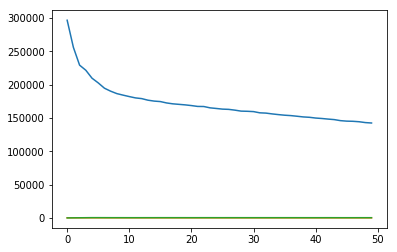

In [387]:
# plot metrics
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['mean_absolute_error'])
pyplot.plot(history.history['mean_absolute_percentage_error'])
pyplot.show()

## The Merge layers

Regresar a: 
1. [Funciones](#Funciones)
2. [PreprossData](#PreprossData)

### (mrna + cnv + meth)

In [27]:
mrna, cnv, meth, dsurv, protein = reRunFiles(varX=True, logSurv=True)
mrna, cnv, meth, dsurv, protein, x_train, x_test, y_train, y_test, cnv_train, cnv_test, meth_train, meth_test, protein_train, protein_test = demoTrainDevSet(mrna, cnv, meth, dsurv, protein)

Dimensiones mrna: (160, 11695)
Dimensiones cnv: (160, 23608)
Dimensiones meth: (160, 13774)
Dimensiones dsurv: (160, 1)
Dimensiones protein: (160, 138)
Nuevas dimensiones mrna: (160, 39)
Nuevas dimensiones cnv: (160, 48)
Nuevas dimensiones meth: (160, 10)
Nuevas dimensiones dsurv: (160, 1)
Nuevas dimensiones protein: (160, 16)


In [12]:
import keras
from keras.layers import Input, Embedding, Dense
from keras.models import Model

Using TensorFlow backend.


In [13]:
def modelKeras(input_shape, neurons):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation="relu")(main_input)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    return nn, main_input

In [14]:
def multiModelKeras(x_train, cnv_train, meth_train):
    mrna_nn, mrna_input = modelKeras(x_train.shape[1:], 100)
    cnv_nn, cnv_input = modelKeras(cnv_train.shape[1:], 10)
    meth_nn, meth_input = modelKeras(meth_train.shape[1:], 10)
    #protein_nn, protein_input = modelKeras(protein_train.shape[1:], 100)
    mrna_cnv_meth = keras.layers.concatenate([mrna_nn, cnv_nn, meth_nn])
    x = Dense(100, activation='relu')(mrna_cnv_meth)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    main_output = Dense(1, activation='relu', name='main_output')(x)
    model = Model(inputs=[mrna_input, cnv_input, meth_input], outputs=main_output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    return model

In [15]:
from sklearn.model_selection import LeaveOneOut

In [16]:
# define 10-fold cross validation test harness
loco = LeaveOneOut()
cvscores = []

In [17]:
def modelKeras(input_shape, neurons):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation="relu")(main_input)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    return nn, main_input

def allToDNN(mrna, cnv, meth, prot, neurons):
    mrnaDNN = modelKeras(mrna.shape[1:], neurons)
    cnvDNN = modelKeras(cnv.shape)

1/1 [==============================] - 0s 78ms/step
MSE: 7.03 Iteracion: 1 
1/1 [==============================] - 0s 117ms/step
MSE: 3.54 Iteracion: 2 
1/1 [==============================] - 0s 163ms/step
MSE: 7.12 Iteracion: 3 
1/1 [==============================] - 0s 238ms/step
MSE: 7.14 Iteracion: 4 
1/1 [==============================] - 0s 258ms/step
MSE: 7.79 Iteracion: 5 
1/1 [==============================] - 0s 291ms/step
MSE: 9.99 Iteracion: 6 
1/1 [==============================] - 0s 351ms/step
MSE: 9.99 Iteracion: 7 
1/1 [==============================] - 0s 466ms/step
MSE: 9.06 Iteracion: 8 
1/1 [==============================] - 0s 451ms/step
MSE: 6.74 Iteracion: 9 
1/1 [==============================] - 1s 518ms/step
MSE: 8.34 Iteracion: 10 
1/1 [==============================] - 1s 563ms/step
MSE: 8.22 Iteracion: 11 
1/1 [==============================] - 1s 617ms/step
MSE: 6.23 Iteracion: 12 
1/1 [==============================] - 1s 742ms/step
MSE: 6.63 Iteracion: 

In [25]:
print(np.mean(cvscores))
print(np.var(cvscores))

6.15448720883578
4.232612277203989


In [367]:
model.fit([x_train, cnv_train, meth_train], y_train,
          epochs=25, batch_size=32)

Epoch 1/25
128/128 [==============================] - 0s 86us/step - loss: 37398.1167 - mean_squared_error: 37398.1167 - mean_absolute_error: 131.2671 - mean_absolute_percentage_error: 137.4021
Epoch 2/25
128/128 [==============================] - 0s 78us/step - loss: 28938.1636 - mean_squared_error: 28938.1636 - mean_absolute_error: 123.2770 - mean_absolute_percentage_error: 181.5998
Epoch 3/25
128/128 [==============================] - 0s 86us/step - loss: 25312.5847 - mean_squared_error: 25312.5847 - mean_absolute_error: 104.1454 - mean_absolute_percentage_error: 104.1512
Epoch 4/25
128/128 [==============================] - 0s 70us/step - loss: 24591.4211 - mean_squared_error: 24591.4211 - mean_absolute_error: 100.2580 - mean_absolute_percentage_error: 127.5200
Epoch 5/25
128/128 [==============================] - 0s 70us/step - loss: 24757.1030 - mean_squared_error: 24757.1030 - mean_absolute_error: 106.6938 - mean_absolute_percentage_error: 152.1975
Epoch 6/25
128/128 [==========

In [366]:
# 50 ephocs
model.evaluate([x_test, cnv_test, meth_test], y_test, batch_size=128)

[137829.875, 137829.875, 276.17135620117188, 107.73342895507813]

In [368]:
# early stop -> 25 stops
model.evaluate([x_test, cnv_test, meth_test], y_test, batch_size=128)

32/32 [==============================] - 0s 31us/step


[134395.875, 134395.875, 272.712646484375, 94.413642883300781]

### Protein + (mrna + cnv + meth)

In [18]:
import keras
from keras.layers import Input, Dropout, Dense
from sklearn.model_selection import LeaveOneOut
from keras.models import Model

In [451]:
def modelKeras(input_shape, neurons):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation="relu")(main_input)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    nn = Dense(neurons, activation="relu")(nn)
    return nn, main_input

In [458]:
def multiModelKerasComplet(x_train, cnv_train, meth_train, protein_input):
    mrna_nn, mrna_input = modelKeras(x_train.shape[1:], 100)
    cnv_nn, cnv_input = modelKeras(cnv_train.shape[1:], 10)
    meth_nn, meth_input = modelKeras(meth_train.shape[1:], 10)
    protein_nn, protein_input = modelKeras(protein_train.shape[1:], 100)
    mrna_cnv_meth = keras.layers.concatenate([mrna_nn, cnv_nn, meth_nn])
    x = Dense(100, activation='relu')(mrna_cnv_meth)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    all_profiles = keras.layers.concatenate([x,protein_nn])
    x = Dense(100, activation='relu')(all_profiles)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    x = Dense(100, activation='relu')(x)
    main_output = Dense(1, activation='relu', name='main_output')(x)
    model = Model(inputs=[mrna_input, cnv_input, meth_input, protein_input], outputs=main_output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    return model

In [460]:
# define 10-fold cross validation test harness
loco = LeaveOneOut()
cvscores = []

In [461]:
for train, test in loco.split(mrna):
    # Crear el modelo
    model = multiModelKerasComplet(mrna, cnv, meth, protein)
    # Fit the model
    model.fit([mrna.iloc[train,:], cnv.iloc[train,:], meth.iloc[train,:], protein.iloc[train,:]], dsurv.iloc[:,1:].iloc[train,:], epochs=150, batch_size=10, verbose=0)
    # Evaluar el modelo
    scores = model.evaluate([mrna.iloc[test,:], cnv.iloc[test,:], meth.iloc[test,:], protein.iloc[test,:]], dsurv.iloc[:,1:].iloc[test,:])
    print("MSE: %.2f%" % (scores[0]))
    cvscores.append(scores[0])

1/1 [==============================] - 15s 15s/step
MSE: 70.47%
1/1 [==============================] - 16s 16s/step
MSE: 676752.38%
1/1 [==============================] - 15s 15s/step
MSE: 6299.31%
1/1 [==============================] - 16s 16s/step
MSE: 12181.06%
1/1 [==============================] - 17s 17s/step
MSE: 72130.54%
1/1 [==============================] - 17s 17s/step
MSE: 1148566.12%
1/1 [==============================] - 19s 19s/step
MSE: 474314.34%
1/1 [==============================] - 18s 18s/step
MSE: 308278.97%
1/1 [==============================] - 17s 17s/step
MSE: 167343.31%
1/1 [==============================] - 18s 18s/step
MSE: 594441.00%
1/1 [==============================] - 18s 18s/step
MSE: 543169.00%
1/1 [==============================] - 21s 21s/step
MSE: 8012.37%
1/1 [==============================] - 21s 21s/step
MSE: 48500.55%
1/1 [==============================] - 22s 22s/step
MSE: 165111.92%
1/1 [==============================] - 26s 26s/step
MSE: 4

KeyboardInterrupt: 

In [377]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])

In [381]:
model.fit([x_train, cnv_train, meth_train, protein_train], y_train,
          epochs=50, batch_size=32)

Epoch 1/50
128/128 [==============================] - 0s 148us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 2/50
128/128 [==============================] - 0s 141us/step - loss: 329726.5312 - mean_squared_error: 329726.5312 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 3/50
128/128 [==============================] - 0s 94us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 4/50
128/128 [==============================] - 0s 86us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 5/50
128/128 [==============================] - 0s 94us/step - loss: 329726.5234 - mean_squared_error: 329726.5234 - mean_absolute_error: 419.2734 - mean_absolute_percentage_error: 100.0000
Epoch 6/50
128/128

In [382]:
# 50 ephocs
model.evaluate([x_test, cnv_test, meth_test, protein_test], y_test, batch_size=128)

32/32 [==============================] - 0s 62us/step


[279155.71875, 279155.71875, 413.15625, 100.0]

In [380]:
# 25 ephocs
model.evaluate([x_test, cnv_test, meth_test, protein_test], y_test, batch_size=128)

32/32 [==============================] - 0s 4ms/step


[279155.71875, 279155.71875, 413.15625, 100.0]

In [59]:
d=[1,2,3,34,4,4,5,566,53,2,2]
d.append(12)
np.mean(d)

57.333333333333336

## mrna + cnv + meth + prot

In [10]:
import keras
from keras.layers import Input, Dropout, Dense
from sklearn.model_selection import LeaveOneOut
from keras.models import Model

Using TensorFlow backend.


In [11]:
mrna, cnv, meth, dsurv, protein = reRunFiles(varX=True, logSurv=True)
mrna, cnv, meth, dsurv, protein, x_train, x_test, y_train, y_test, cnv_train, cnv_test, meth_train, meth_test, protein_train, protein_test = demoTrainDevSet(mrna, cnv, meth, dsurv, protein)

Dimensiones mrna: (160, 11695)
Dimensiones cnv: (160, 23608)
Dimensiones meth: (160, 13774)
Dimensiones dsurv: (160, 1)
Dimensiones protein: (160, 138)
Nuevas dimensiones mrna: (160, 39)
Nuevas dimensiones cnv: (160, 48)
Nuevas dimensiones meth: (160, 10)
Nuevas dimensiones dsurv: (160, 1)
Nuevas dimensiones protein: (160, 16)


In [12]:
def modelKeras(input_shape, neurons, dropOut, activation):
    main_input = Input(shape=(input_shape)) #inputshape=x_train.shape[1:]
    nn = Dense(neurons, activation=activation)(main_input)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    nn = Dense(neurons, activation=activation)(nn)
    nn = Dropout(dropOut)(nn)
    return nn, main_input

def allToDNN(mrna, cnv, meth, prot, neurons, dropOut, activation):
    mrnaDNN, mrnaInput = modelKeras(mrna.shape[1:], neurons, dropOut, activation)
    cnvDNN, cnvInput = modelKeras(cnv.shape[1:], neurons, dropOut, activation)
    methDNN, methInput = modelKeras(meth.shape[1:], neurons, dropOut, activation)
    proteinDNN, proteinInput = modelKeras(protein.shape[1:], neurons, dropOut, activation)
    
    all_profiles = keras.layers.concatenate([mrnaDNN, cnvDNN, methDNN, proteinDNN])
    
    x = Dense(neurons, activation=activation)(all_profiles)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    x = Dense(neurons, activation=activation)(x)
    x = Dropout(dropOut)(x)
    main_output = Dense(1, activation=activation, name='main_output')(x)
    
    model = Model(inputs=[mrnaInput, cnvInput, methInput, proteinInput], outputs=main_output)
    #model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [22]:
#model = allToDNN(mrna, cnv, meth, protein, neurons=100, dropOut=.5, activation="relu")
#model.fit([mrna, cnv, meth, protein], dsurv, epochs=100, verbose=1, validation_split=0.2)

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 8s 61ms/step - loss: 1096575.9375 - mean_squared_error: 1096575.9375 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 2/100
128/128 [==============================] - 0s 617us/step - loss: 125130.7521 - mean_squared_error: 125130.7521 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 3/100
128/128 [==============================] - 0s 609us/step - loss: 2049.7347 - mean_squared_error: 2049.7347 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 4/100
128/128 [==============================] - 0s 625us/step - loss: 1169.6099 - mean_squared_error: 1169.6099 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 5/100
128/128 [==============================] - 0s 586us/step - loss: 59.4431 - mean_squared_error: 59.4431 - val_loss: 5.7162 - val_mean_squared_error: 5.7162
Epoch 6/100
128/128 [==============================] - 0s 594us/step - loss: 104.5673 - mean_sq

## Evaluacion de parametros

In [17]:
# Parametros a evaluar
parametros = {
    "neurons":[10,100, 500, 1000, 5000],
    "dropOut":[0,.2,.4,.6,.8], 
    "activation":["selu", "relu" ,"tanh", "sigmoid", "hard_sigmoid"]
}

In [ ]:
keysParams=list(parametros.keys())
consolidado = {}
for neuron in parametros[keysParams[0]]:
    for drop in parametros[keysParams[1]]:
        for activ in parametros[keysParams[2]]:
            saveEval=[]
            for ix_train, ix_test in kfoldProfiles(mrna, n_splits=3, seed=10):
                mrna_train=mrna.iloc[ix_train,]
                mrna_test=mrna.iloc[ix_test,]
                cnv_train=cnv.iloc[ix_train,]
                cnv_test=cnv.iloc[ix_test,]
                meth_train=meth.iloc[ix_train,]
                meth_test=meth.iloc[ix_test,]
                protein_train=protein.iloc[ix_train,]
                protein_test=protein.iloc[ix_test,]
                dsurv_train=dsurv.iloc[ix_train,]
                dsurv_test=dsurv.iloc[ix_test,]

                model = allToDNN(mrna_train, cnv_train, meth_train, protein_train, neurons=neuron, dropOut=drop, activation=activ)
                model.fit([mrna_train, cnv_train, meth_train, protein_train], dsurv_train, epochs=100, verbose=0)
                saveEval.append(model.evaluate([mrna_test, cnv_test, meth_test, protein_test], dsurv_test, batch_size=20)[1])
            consolidado["neuron: " + str(neuron) + " - " + "dropOut: " + str(drop) + " - " + "activation: " + str(activ)] = [np.mean(saveEval), np.var(saveEval)]

53/53 [==============================] - 456s 9s/step


In [ ]:
parametros = {
    "activation": ["softmax", "elu", "selu", "softplus", "softsign", "relu" ,"tanh", "sigmoid", "hard_sigmoid", "linear"],
    "optimizer": ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax", "Nadam"], 
    "drop": [0.2,0.4,0.6,0.8,1],
    "kernel": ["random_normal", "he_uniform", "lecun_normal", "he_normal", "glorot_uniform", "glorot_normal", "lecun_uniform", "zeros", "ones"], 
    "neurons": [5,10,50,100]
    #"moreHiddenLayers": [True, False]
}

In [16]:
consolidado

{'neuron: 10 dropOut: 0 activation: hard_sigmoid': [2.2893303602933885,
  0.07045023477055755],
 'neuron: 10 dropOut: 0 activation: relu': [1.6679292343556882,
  6.45233401136309],
 'neuron: 10 dropOut: 0 activation: selu': [0.3523627985268831,
  0.014645620210377802],
 'neuron: 10 dropOut: 0 activation: sigmoid': [2.4670102894306183,
  0.10756802981772502],
 'neuron: 10 dropOut: 0 activation: tanh': [2.297404333949089,
  0.07010535185744544],
 'neuron: 10 dropOut: 0.2 activation: hard_sigmoid': [2.2893303602933885,
  0.07045023477055755],
 'neuron: 10 dropOut: 0.2 activation: relu': [0.32286396585404875,
  0.0030789831382900096],
 'neuron: 10 dropOut: 0.2 activation: selu': [0.2735787585377693,
  0.01177260077224105],
 'neuron: 10 dropOut: 0.2 activation: sigmoid': [2.448762908577919,
  0.14871793601046496],
 'neuron: 10 dropOut: 0.2 activation: tanh': [2.2908347874879835,
  0.07061441219766967],
 'neuron: 10 dropOut: 0.4 activation: hard_sigmoid': [2.2893303602933885,
  0.07045023477

******************************************************************************************************************************************

### Usando un cluster - "Dask"

No para keras?

In [269]:
from dask.distributed import Client
client = Client(processes=False)
client

<Client: scheduler='inproc://157.253.199.132/10012/19' processes=1 cores=8>

In [270]:
import dask_ml.joblib
from sklearn.externals import joblib